### this script is to extract events using odds ratio, do calibration based on the templates and finally plot the figures that will be needed in the paper

In [1]:
import pandas as pd
df_m = pd.read_csv("../data/ee-fm/df_m.csv")
df_f = pd.read_csv("../data/ee-fm/df_f.csv")

In [3]:
import itertools
import spacy
import ast 

nlp = spacy.load('en')
sp = spacy.load('en_core_web_sm')
all_stopwords = sp.Defaults.stop_words

def chain(array):
    array = ast.literal_eval(array)
    return list(itertools.chain.from_iterable(array))

def events_only(array):
    events = []
    if(len(array) > 0):
        for event in array:
            trigger_word = event["triggers"][0]["text"]
            w = nlp(trigger_word)
            if w[0].lemma_ not in all_stopwords:
                events.append(w[0].lemma_)
    return events

In [4]:
def extract_events(df_nomi_female):
    df_nomi_female["pl_events"] = df_nomi_female["personal_life"].apply(chain)
    df_nomi_female["pl_ev_lemma"] = df_nomi_female["pl_events"].apply(events_only)
    df_nomi_female["career_events"] = df_nomi_female["career"].apply(chain)
    df_nomi_female["career_ev_lemma"] = df_nomi_female["career_events"].apply(events_only)
    df_nomi_female["pl_ev_num"] = df_nomi_female["pl_ev_lemma"].apply(len)
    df_nomi_female["cr_ev_num"] = df_nomi_female["career_ev_lemma"].apply(len)
    return df_nomi_female

## odds ratio calculation function
### *--------------------------------------------------------*

In [5]:
def odds_ratio(f_dict, m_dict, topk=50, threshold=2):
    very_small_value = 0.00001
    if len(f_dict.keys()) != len(m_dict.keys()):
        raise Exception("The category for analyzing the male and female should be the same!")
    else:
        odds_ratio = {}
        total_num_f = sum(f_dict.values())
        total_num_m = sum(m_dict.values())
        for key in f_dict.keys():
            m_num = m_dict[key]
            f_num = f_dict[key]
            non_f_num = total_num_f - f_num
            non_m_num = total_num_m - m_num
            if f_num >= threshold and m_num >= threshold:
                # we only consider the events where there are at least {thresohld} occurences for both gender
                odds_ratio[key] = round((m_num / f_num) / (non_m_num / non_f_num), 2)
            else:
                continue
        return dict(sorted(odds_ratio.items(), key=itemgetter(1), reverse=True)[:topk]), dict(
            sorted(odds_ratio.items(), key=itemgetter(1))[:topk])

### *--------------------------------------------------------*

In [6]:
import pickle
import itertools
import spacy
from operator import itemgetter
from collections import Counter
import logging
from datetime import datetime
import numpy as np

In [7]:
df_m = extract_events(df_m)
df_f = extract_events(df_f)

In [8]:
def calculate_dict(female_array, male_array):
    counter_f_h = Counter(female_array)
    counter_m_h = Counter(male_array)
    
    # make sure there is no key lookup error
    for key in set(counter_f_h) - set(counter_m_h):
        counter_m_h[key] = 0
    for key in set(counter_m_h) - set(counter_f_h):
        counter_f_h[key] = 0

    return counter_f_h, counter_m_h

In [9]:
def counter_odds_career(career_evs_female, career_evs_male):
    counter_f_c, counter_m_c = calculate_dict(career_evs_female, career_evs_male)
    odds_m_c, odds_f_c = odds_ratio(counter_f_c, counter_m_c)
    return counter_f_c, counter_m_c, odds_m_c, odds_f_c

def check_keyword(array):
    return keyword in array

In [10]:
# there are two ways to do the chain list function: one is applicable to career
# the other is applicable to the personal life section, please choose the one based on the data
def chain_list(array):
    array_new = []
    for i in array:
        array_new.append(ast.literal_eval(i))
    return (list(itertools.chain.from_iterable(array_new)))

def chain_list(array):
    return list(itertools.chain.from_iterable(array))

In [11]:
new_occupations = ["writers", "acting", "comedians", "podcasters", "dancers", "artists", "chefs", "musicians"]
result_counter = {}
result_odds = {}
for new_occupation in new_occupations:
    print("occupation: ", new_occupation)
    df_m_occ, df_f_occ = df_m[df_m["occupation"] == new_occupation], df_f[df_f["occupation"] == new_occupation]
    # to make sure there are equal size of celebrities 
    thres = min(len(df_m_occ), len(df_f_occ))
    df_m_occ, df_f_occ = df_m_occ[:thres], df_f_occ[:thres]
#     pl_evs_f, pl_evs_m = chain(df_female_ev["pl_ev_lemma"]), chain(df_male_ev["pl_ev_lemma"])
    cr_evs_f, cr_evs_m = chain_list(df_f_occ["pl_ev_lemma"].to_list()), chain_list(df_m_occ["pl_ev_lemma"].to_list())
    counter_f_c, counter_m_c, odds_m_c, odds_f_c = counter_odds_career(cr_evs_f, cr_evs_m)
    result_counter[new_occupation] = {
        "female": counter_f_c,
        "male": counter_m_c
    }
    result_odds[new_occupation] = {
        "female": odds_f_c,
        "male": odds_m_c
    }

occupation:  writers
occupation:  acting
occupation:  comedians
occupation:  podcasters
occupation:  dancers
occupation:  artists
occupation:  chefs
occupation:  musicians


In [12]:
for occupation in new_occupations:
    print("occupation: ", occupation)
    # before calibration
    # "female top 10"
    print("*"*10 + "female top 10" + "*"*10)
    print(list(result_odds[occupation]["female"].keys())[:10])
    # "male top 10"
    print("*"*10 + "male top 10" + "*"*10)
    print(list(result_odds[occupation]["male"].keys())[:10])


occupation:  writers
**********female top 10**********
['bury', 'die', 'birth', 'attend', 'war', 'grow', 'serve', 'appear', 'raise', 'begin']
**********male top 10**********
['publish', 'know', 'report', 'come', 'charge', 'undergo', 'suffer', 'claim', 'state', 'return']
occupation:  acting
**********female top 10**********
['pregnant', 'practice', 'wedding', 'record', 'convert', 'honor', 'battle', 'gain', 'retire', 'bring']
**********male top 10**********
['accuse', 'trip', 'fly', 'assault', 'fight', 'endorse', 'award', 'meeting', 'spend', 'donate']
occupation:  comedians
**********female top 10**********
['fall', 'open', 'diagnose', 'decide', 'birth', 'tweet', 'study', 'date', 'feel', 'turn']
**********male top 10**********
['create', 'spend', 'lawsuit', 'propose', 'accord', 'arrest', 'find', 'visit', 'sell', 'admit']
occupation:  podcasters
**********female top 10**********
['date', 'describe', 'tell', 'life', 'come', 'engage', 'live', 'work', 'start', 'reside']
**********male top 10

## calibration step1: get <em>template sentences</em>

In [14]:
final = pd.read_csv("data/final_manual.csv")
templates = pd.DataFrame(final).drop_duplicates(subset=['Name', "Gender", "Occupation"])

In [15]:
templates.head(10)

,Event,Name,Gender,Occupation,Keyword,Text
0,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Dolester Miles,F,chefs,hire,"In 1982, Frank Stitt opened Highlands Bar and ..."
1,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Nancy Silverton,F,chefs,hire,After Silverton returned to Los Angeles in 198...
2,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Beau MacMillan,M,chefs,hire,MacMillan moved to Los Angeles to become sous ...
3,"{'text': 'hired', 'lemma': 'hire', 'start_toke...",Anthony Amoroso,M,chefs,hire,"In 2003, Amoroso relocated to Las Vegas, Nevad..."
4,"{'text': 'met', 'lemma': 'meet', 'start_token'...",Debra Ponzek,F,chefs,meet,Ponzek married fellow chef Bobby Flay in May 1...
5,"{'text': 'met', 'lemma': 'meet', 'start_token'...",Ashleigh Shanti,F,chefs,meet,"In October 2018, Shanti met John Fleer, owner-..."
6,"{'text': 'met', 'lemma': 'meet', 'start_token'...",Ettore Boiardi,M,chefs,meet,"In 1927, Boiardi met Maurice and Eva Weiner wh..."
7,"{'text': 'sold', 'lemma': 'sell', 'start_token...",Ida Bailey Allen,F,chefs,sell,In 1924 Allen was food editor of the Sunday Ne...
9,"{'text': 'selling', 'lemma': 'sell', 'start_to...",Iliana Regan,F,chefs,sell,"In 2008, Regan began selling microgreens and v..."
10,"{'text': 'sold', 'lemma': 'sell', 'start_token...",Peter Grunauer,M,chefs,sell,"In 1979, Peter was joined by Karl Zartler, who..."


In [16]:
# not reporting some of the occupations because of the small data size
selected_occupation = ["dancers", "comedians", "podcasters", "writers", "artists", "musicians", "chefs"]
select_templates = templates[templates["Occupation"].isin(selected_occupation)]

## calibration step 2: based on the <em>template sentences</em>, swap names and get new sentences for calibration

In [17]:
import re 
import json

def swap_female(current_name, current_gender, text, future_name, future_gender):
    current_name = re.sub("[\(\[].*?[\)\]]", "", current_name)
    first_name = current_name.split(" ")[-1]  
    re_dict = {
        first_name: future_name,
    }
    if current_gender == "F" and future_gender == "M":
        re_dict["she"] = "he"
        re_dict["her"] = "his"
        re_dict["She"] = "He"
        re_dict["Her"] = "His"
    elif current_gender == "M" and future_gender == "F":
        re_dict["he"] = "she"
        re_dict["his"] = "her"
        re_dict["him"] = "her"
        re_dict["He"] = "She"
        re_dict["His"] = "Her"
        
    print(re_dict)
 
    new_tokens = []
    for token in nlp(text):
        if token.text in re_dict.keys():
            new_tokens.append(re_dict[token.text])
        else:
            new_tokens.append(token.text)
    replaced_string = " ".join(ele for ele in new_tokens)
    return replaced_string

In [18]:
# for single events, do event detection
name_list = json.loads(open("../data/names.json", "rb").readlines()[0])

# fifty sample names
sample_name = 50
male_names = name_list["men"][:50]
female_names = name_list["women"][:50]

In [19]:
gen_sen = []
for i, row in select_templates.iterrows():
    original_text = row["Text"]
    cur_gender = row["Gender"]
    cur_name = row["Name"]
    f_gens = ["M", "F"]
    for f_gen in f_gens:
        if f_gen == "M":
            for name in male_names:
                future_text =  swap_female(cur_name, cur_gender, original_text, name, f_gen)
                gen_sen.append({
                    "Event":row["Event"],
                    "Name": name,
                    "Gender": f_gen,
                    "Occupation": row["Occupation"],
                    "Keyword": row["Keyword"],
                    "Text": future_text
                })
        if f_gen == "F":
            for name in female_names:
                future_text =  swap_female(cur_name, cur_gender, original_text, name, f_gen)
                gen_sen.append({
                    "Event":row["Event"],
                    "Name": name,
                    "Gender": f_gen,
                    "Occupation": row["Occupation"],
                    "Keyword": row["Keyword"],
                    "Text": future_text
                })

{'Miles': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Miles': 'Ryan', 'she': 'he', 'her

{'Silverton': 'Jennifer'}
{'Silverton': 'Jessica'}
{'Silverton': 'Ashley'}
{'Silverton': 'Sarah'}
{'Silverton': 'Emily'}
{'Silverton': 'Amanda'}
{'Silverton': 'Elizabeth'}
{'Silverton': 'Melissa'}
{'Silverton': 'Stephanie'}
{'Silverton': 'Samantha'}
{'Silverton': 'Michelle'}
{'Silverton': 'Kimberly'}
{'Silverton': 'Amy'}
{'Silverton': 'Heather'}
{'Silverton': 'Rachel'}
{'Silverton': 'Lauren'}
{'Silverton': 'Rebecca'}
{'Silverton': 'Angela'}
{'Silverton': 'Emma'}
{'Silverton': 'Megan'}
{'Silverton': 'Taylor'}
{'Silverton': 'Olivia'}
{'Silverton': 'Hannah'}
{'Silverton': 'Alexis'}
{'Silverton': 'Madison'}
{'Silverton': 'Christina'}
{'Silverton': 'Lisa'}
{'Silverton': 'Mary'}
{'Silverton': 'Amber'}
{'Silverton': 'Kelly'}
{'Silverton': 'Abigail'}
{'Silverton': 'Brittany'}
{'Silverton': 'Laura'}
{'Silverton': 'Danielle'}
{'Silverton': 'Victoria'}
{'Silverton': 'Katherine'}
{'Silverton': 'Kayla'}
{'Silverton': 'Tiffany'}
{'Silverton': 'Andrea'}
{'Silverton': 'Sophia'}
{'Silverton': 'Isabella

{'Amoroso': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Amoroso': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}


{'Ponzek': 'Rebecca'}
{'Ponzek': 'Angela'}
{'Ponzek': 'Emma'}
{'Ponzek': 'Megan'}
{'Ponzek': 'Taylor'}
{'Ponzek': 'Olivia'}
{'Ponzek': 'Hannah'}
{'Ponzek': 'Alexis'}
{'Ponzek': 'Madison'}
{'Ponzek': 'Christina'}
{'Ponzek': 'Lisa'}
{'Ponzek': 'Mary'}
{'Ponzek': 'Amber'}
{'Ponzek': 'Kelly'}
{'Ponzek': 'Abigail'}
{'Ponzek': 'Brittany'}
{'Ponzek': 'Laura'}
{'Ponzek': 'Danielle'}
{'Ponzek': 'Victoria'}
{'Ponzek': 'Katherine'}
{'Ponzek': 'Kayla'}
{'Ponzek': 'Tiffany'}
{'Ponzek': 'Andrea'}
{'Ponzek': 'Sophia'}
{'Ponzek': 'Isabella'}
{'Ponzek': 'Anna'}
{'Ponzek': 'Natalie'}
{'Ponzek': 'Alyssa'}
{'Ponzek': 'Erin'}
{'Ponzek': 'Jamie'}
{'Ponzek': 'Maria'}
{'Ponzek': 'Sara'}
{'Ponzek': 'Shannon'}
{'Ponzek': 'Nancy'}
{'Shanti': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shanti': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shanti': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shanti': 'David', 'she': 'he', 'her': 'his', 'She': 

{'Boiardi': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Boiardi': '

{'Regan': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Regan': 'Timothy', 'she': 'he', 

{'Grunauer': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Grunauer': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'':

{'Goin': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goin': 'Jennifer'}
{'Goin': 'Jessica'}
{'Goin': 'Ashley'}
{'Goin': 'Sarah'}
{'Goin': 'Emily'}
{'Goin': 'Amanda'}
{'Goin': 'Eliza

{'Lodge': 'Jose'}
{'Lodge': 'Jeremy'}
{'Lodge': 'Ethan'}
{'Lodge': 'Christian'}
{'Lodge': 'Austin'}
{'Lodge': 'Noah'}
{'Lodge': 'Dylan'}
{'Lodge': 'Scott'}
{'Lodge': 'Sean'}
{'Lodge': 'Patrick'}
{'Lodge': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lodge': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lod

{'Burrell': 'Jessica'}
{'Burrell': 'Ashley'}
{'Burrell': 'Sarah'}
{'Burrell': 'Emily'}
{'Burrell': 'Amanda'}
{'Burrell': 'Elizabeth'}
{'Burrell': 'Melissa'}
{'Burrell': 'Stephanie'}
{'Burrell': 'Samantha'}
{'Burrell': 'Michelle'}
{'Burrell': 'Kimberly'}
{'Burrell': 'Amy'}
{'Burrell': 'Heather'}
{'Burrell': 'Rachel'}
{'Burrell': 'Lauren'}
{'Burrell': 'Rebecca'}
{'Burrell': 'Angela'}
{'Burrell': 'Emma'}
{'Burrell': 'Megan'}
{'Burrell': 'Taylor'}
{'Burrell': 'Olivia'}
{'Burrell': 'Hannah'}
{'Burrell': 'Alexis'}
{'Burrell': 'Madison'}
{'Burrell': 'Christina'}
{'Burrell': 'Lisa'}
{'Burrell': 'Mary'}
{'Burrell': 'Amber'}
{'Burrell': 'Kelly'}
{'Burrell': 'Abigail'}
{'Burrell': 'Brittany'}
{'Burrell': 'Laura'}
{'Burrell': 'Danielle'}
{'Burrell': 'Victoria'}
{'Burrell': 'Katherine'}
{'Burrell': 'Kayla'}
{'Burrell': 'Tiffany'}
{'Burrell': 'Andrea'}
{'Burrell': 'Sophia'}
{'Burrell': 'Isabella'}
{'Burrell': 'Anna'}
{'Burrell': 'Natalie'}
{'Burrell': 'Alyssa'}
{'Burrell': 'Erin'}
{'Burrell': 'Jamie

{'Deen': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Deen': 'Hannah', 'he': 'she', 'his': 'her',

{'Symensma': 'Joshua'}
{'Symensma': 'Daniel'}
{'Symensma': 'Joseph'}
{'Symensma': 'William'}
{'Symensma': 'Robert'}
{'Symensma': 'Andrew'}
{'Symensma': 'Jason'}
{'Symensma': 'Ryan'}
{'Symensma': 'Anthony'}
{'Symensma': 'Jacob'}
{'Symensma': 'Nicholas'}
{'Symensma': 'Brian'}
{'Symensma': 'Justin'}
{'Symensma': 'Jonathan'}
{'Symensma': 'Brandon'}
{'Symensma': 'Kevin'}
{'Symensma': 'Thomas'}
{'Symensma': 'Eric'}
{'Symensma': 'Benjamin'}
{'Symensma': 'Alexander'}
{'Symensma': 'Tyler'}
{'Symensma': 'Steven'}
{'Symensma': 'Timothy'}
{'Symensma': 'Zachary'}
{'Symensma': 'Charles'}
{'Symensma': 'Richard'}
{'Symensma': 'Aaron'}
{'Symensma': 'Adam'}
{'Symensma': 'Jordan'}
{'Symensma': 'Nathan'}
{'Symensma': 'Samuel'}
{'Symensma': 'Kyle'}
{'Symensma': 'Mark'}
{'Symensma': 'Jeffrey'}
{'Symensma': 'Jose'}
{'Symensma': 'Jeremy'}
{'Symensma': 'Ethan'}
{'Symensma': 'Christian'}
{'Symensma': 'Austin'}
{'Symensma': 'Noah'}
{'Symensma': 'Dylan'}
{'Symensma': 'Scott'}
{'Symensma': 'Sean'}
{'Symensma': 'Pa

{'Saad': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Saad': 'Danielle', 'he': 'she', 'his': 'h

{'Kaysen': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kaysen': 

{'Child': 'Christina'}
{'Child': 'Lisa'}
{'Child': 'Mary'}
{'Child': 'Amber'}
{'Child': 'Kelly'}
{'Child': 'Abigail'}
{'Child': 'Brittany'}
{'Child': 'Laura'}
{'Child': 'Danielle'}
{'Child': 'Victoria'}
{'Child': 'Katherine'}
{'Child': 'Kayla'}
{'Child': 'Tiffany'}
{'Child': 'Andrea'}
{'Child': 'Sophia'}
{'Child': 'Isabella'}
{'Child': 'Anna'}
{'Child': 'Natalie'}
{'Child': 'Alyssa'}
{'Child': 'Erin'}
{'Child': 'Jamie'}
{'Child': 'Maria'}
{'Child': 'Sara'}
{'Child': 'Shannon'}
{'Child': 'Nancy'}
{'Saffitz': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Saffitz': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Saffitz': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Saffitz': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Saffitz': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Saffitz': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Saffitz': 'Joshua', 'she': 'he', 'her'

{'Moulton': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Moulton': 'Jennifer'}
{'Moulton': 'Jessica'}
{'Moulton': 'Ashley'}
{'Moulton': 'Sarah'}
{'Moulton': 'Emily'}
{'Moulton': 'Amanda'}
{'Moulton': 'Elizabeth'}
{'Moulton'

{'Largey': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Largey': 'Steven',

{'Lightner': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lightner': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'

{'Howard': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Howard': 'Jordan', 's

{'Chachere': 'William'}
{'Chachere': 'Robert'}
{'Chachere': 'Andrew'}
{'Chachere': 'Jason'}
{'Chachere': 'Ryan'}
{'Chachere': 'Anthony'}
{'Chachere': 'Jacob'}
{'Chachere': 'Nicholas'}
{'Chachere': 'Brian'}
{'Chachere': 'Justin'}
{'Chachere': 'Jonathan'}
{'Chachere': 'Brandon'}
{'Chachere': 'Kevin'}
{'Chachere': 'Thomas'}
{'Chachere': 'Eric'}
{'Chachere': 'Benjamin'}
{'Chachere': 'Alexander'}
{'Chachere': 'Tyler'}
{'Chachere': 'Steven'}
{'Chachere': 'Timothy'}
{'Chachere': 'Zachary'}
{'Chachere': 'Charles'}
{'Chachere': 'Richard'}
{'Chachere': 'Aaron'}
{'Chachere': 'Adam'}
{'Chachere': 'Jordan'}
{'Chachere': 'Nathan'}
{'Chachere': 'Samuel'}
{'Chachere': 'Kyle'}
{'Chachere': 'Mark'}
{'Chachere': 'Jeffrey'}
{'Chachere': 'Jose'}
{'Chachere': 'Jeremy'}
{'Chachere': 'Ethan'}
{'Chachere': 'Christian'}
{'Chachere': 'Austin'}
{'Chachere': 'Noah'}
{'Chachere': 'Dylan'}
{'Chachere': 'Scott'}
{'Chachere': 'Sean'}
{'Chachere': 'Patrick'}
{'Chachere': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'h

{'Harlan': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harlan': 'Abigail', 'h

{'Kass': 'Ethan'}
{'Kass': 'Christian'}
{'Kass': 'Austin'}
{'Kass': 'Noah'}
{'Kass': 'Dylan'}
{'Kass': 'Scott'}
{'Kass': 'Sean'}
{'Kass': 'Patrick'}
{'Kass': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kass': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her'

{'Iuzzini': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Iuzzini': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'

{'Fieri': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fieri': 'Kelly', 'he': 'she', 'his

{'Carmellini': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Carmellini': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Carmellini': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Carmellini': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Carmellini': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Esposito': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Esposito': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Esposito': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Esposito': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Esposito': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Esposito': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Esposito': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His

{'Bastianich': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bastianich': 'Scott', 'she': 'he', 'her': 'his', 'She': 

{'Samuelsson': 'Daniel'}
{'Samuelsson': 'Joseph'}
{'Samuelsson': 'William'}
{'Samuelsson': 'Robert'}
{'Samuelsson': 'Andrew'}
{'Samuelsson': 'Jason'}
{'Samuelsson': 'Ryan'}
{'Samuelsson': 'Anthony'}
{'Samuelsson': 'Jacob'}
{'Samuelsson': 'Nicholas'}
{'Samuelsson': 'Brian'}
{'Samuelsson': 'Justin'}
{'Samuelsson': 'Jonathan'}
{'Samuelsson': 'Brandon'}
{'Samuelsson': 'Kevin'}
{'Samuelsson': 'Thomas'}
{'Samuelsson': 'Eric'}
{'Samuelsson': 'Benjamin'}
{'Samuelsson': 'Alexander'}
{'Samuelsson': 'Tyler'}
{'Samuelsson': 'Steven'}
{'Samuelsson': 'Timothy'}
{'Samuelsson': 'Zachary'}
{'Samuelsson': 'Charles'}
{'Samuelsson': 'Richard'}
{'Samuelsson': 'Aaron'}
{'Samuelsson': 'Adam'}
{'Samuelsson': 'Jordan'}
{'Samuelsson': 'Nathan'}
{'Samuelsson': 'Samuel'}
{'Samuelsson': 'Kyle'}
{'Samuelsson': 'Mark'}
{'Samuelsson': 'Jeffrey'}
{'Samuelsson': 'Jose'}
{'Samuelsson': 'Jeremy'}
{'Samuelsson': 'Ethan'}
{'Samuelsson': 'Christian'}
{'Samuelsson': 'Austin'}
{'Samuelsson': 'Noah'}
{'Samuelsson': 'Dylan'}
{'

{'Prudhomme': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prudhomme': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 

{'Thornton': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thornton': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'Hi

{'Allen': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Tiffany', 'he': 'sh

{'Figueroa': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Figueroa': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her'

{'Peacock': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Peacock': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Peacock': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Peacock': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Peacock': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cosentino': 'Michael'}
{'Cosentino': 'Christopher'}
{'Cosentino': 'Matthew'}
{'Cosentino': 'David'}
{'Cosentino': 'James'}
{'Cosentino': 'John'}
{'Cosentino': 'Joshua'}
{'Cosentino': 'Daniel'}
{'Cosentino': 'Joseph'}
{'Cosentino': 'William'}
{'Cosentino': 'Robert'}
{'Cosentino': 'Andrew'}
{'Cosentino': 'Jason'}
{'Cosentino': 'Ryan'}
{'Cosentino': 'Anthony'}
{'Cosentino': 'Jacob'}
{'Cosentino': 'Nicholas'}
{'Cosentino': 'Brian'}
{'Cosentino': 'Justin'}
{'Cosentino': 'Jonathan'}
{'Cosentino': 'Brandon'}
{'Cosentino': 'Kevin'}
{'Cosentino': 'Thomas'

{'Bishop': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bishop': 'Alexis', 'he'

{'Virant': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Virant': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Virant': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Virant': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Virant': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Virant': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Puma': 'Michael'}
{'Puma': 'Christopher'}
{'Puma': 'Matthew'}
{'Puma': 'David'}
{'Puma': 'James'}
{'Puma': 'John'}
{'Puma': 'Joshua'}
{'Puma': 'Daniel'}
{'Puma': 'Joseph'}
{'Puma': 'William'}
{'Puma': 'Robert'}
{'Puma': 'Andrew'}
{'Puma': 'Jason'}
{'Puma': 'Ryan'}
{'Puma': 'Anthony'}
{'Puma': 'Jacob'}
{'Puma': 'Nicholas'}
{'Puma': 'Brian'}
{'Puma': 'Justin'}
{'Puma': 'Jonathan'}
{'Puma': 'Brandon'}
{'Puma': 'Kevin'}
{'Puma': 'Thomas'}
{'Puma': 'Eric'}
{'Puma': 'Benj

{'': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{

{'Taylor': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Ethan', 'she': 'he

{'Marks': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marks': 'Nicholas', 'she': 'he', 'her': 'h

{'Mars': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mars': 'Sara', 'he': 'she', 'his': 'her', 'h

{'Greene': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Greene': 'Christian', 'she': '

{'Samant': 'Thomas'}
{'Samant': 'Eric'}
{'Samant': 'Benjamin'}
{'Samant': 'Alexander'}
{'Samant': 'Tyler'}
{'Samant': 'Steven'}
{'Samant': 'Timothy'}
{'Samant': 'Zachary'}
{'Samant': 'Charles'}
{'Samant': 'Richard'}
{'Samant': 'Aaron'}
{'Samant': 'Adam'}
{'Samant': 'Jordan'}
{'Samant': 'Nathan'}
{'Samant': 'Samuel'}
{'Samant': 'Kyle'}
{'Samant': 'Mark'}
{'Samant': 'Jeffrey'}
{'Samant': 'Jose'}
{'Samant': 'Jeremy'}
{'Samant': 'Ethan'}
{'Samant': 'Christian'}
{'Samant': 'Austin'}
{'Samant': 'Noah'}
{'Samant': 'Dylan'}
{'Samant': 'Scott'}
{'Samant': 'Sean'}
{'Samant': 'Patrick'}
{'Samant': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Samant': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Samant': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Samant': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Samant': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her'

{'Mahier': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mahier': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mahier': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mahier': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mahier': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mahier': 'Jennifer'}
{'Mahier': 'Jessica'}
{'Mahier': 'Ashley'}
{'Mahier': 'Sarah'}
{'Mahier': 'Emily'}
{'Mahier': 'Amanda'}
{'Mahier': 'Elizabeth'}
{'Mahier': 'Melissa'}
{'Mahier': 'Stephanie'}
{'Mahier': 'Samantha'}
{'Mahier': 'Michelle'}
{'Mahier': 'Kimberly'}
{'Mahier': 'Amy'}
{'Mahier': 'Heather'}
{'Mahier': 'Rachel'}
{'Mahier': 'Lauren'}
{'Mahier': 'Rebecca'}
{'Mahier': 'Angela'}
{'Mahier': 'Emma'}
{'Mahier': 'Megan'}
{'Mahier': 'Taylor'}
{'Mahier': 'Olivia'}
{'Mahier': 'Hannah'}
{'Mahier': 'Alexis'}
{'Mahier': 'Madison'}
{'Mahier': 'Christina'}
{'Mahier': 'Lisa'}
{'Mahier': 'Mary'}
{'Mahier': 'Amber'}
{'Mahier': '

{'': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'':

{'Poole': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Poole': 'Steven', 'she': 'he', 

{'MrBeast': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MrBeast': 'N

{'Onofrio': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Onofrio': 'Aust

{'Kreisinger': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kreisinger': 'Brian', 'she': 'he', 'her': 'his', 'Sh

{'Hicks': 'Jennifer'}
{'Hicks': 'Jessica'}
{'Hicks': 'Ashley'}
{'Hicks': 'Sarah'}
{'Hicks': 'Emily'}
{'Hicks': 'Amanda'}
{'Hicks': 'Elizabeth'}
{'Hicks': 'Melissa'}
{'Hicks': 'Stephanie'}
{'Hicks': 'Samantha'}
{'Hicks': 'Michelle'}
{'Hicks': 'Kimberly'}
{'Hicks': 'Amy'}
{'Hicks': 'Heather'}
{'Hicks': 'Rachel'}
{'Hicks': 'Lauren'}
{'Hicks': 'Rebecca'}
{'Hicks': 'Angela'}
{'Hicks': 'Emma'}
{'Hicks': 'Megan'}
{'Hicks': 'Taylor'}
{'Hicks': 'Olivia'}
{'Hicks': 'Hannah'}
{'Hicks': 'Alexis'}
{'Hicks': 'Madison'}
{'Hicks': 'Christina'}
{'Hicks': 'Lisa'}
{'Hicks': 'Mary'}
{'Hicks': 'Amber'}
{'Hicks': 'Kelly'}
{'Hicks': 'Abigail'}
{'Hicks': 'Brittany'}
{'Hicks': 'Laura'}
{'Hicks': 'Danielle'}
{'Hicks': 'Victoria'}
{'Hicks': 'Katherine'}
{'Hicks': 'Kayla'}
{'Hicks': 'Tiffany'}
{'Hicks': 'Andrea'}
{'Hicks': 'Sophia'}
{'Hicks': 'Isabella'}
{'Hicks': 'Anna'}
{'Hicks': 'Natalie'}
{'Hicks': 'Alyssa'}
{'Hicks': 'Erin'}
{'Hicks': 'Jamie'}
{'Hicks': 'Maria'}
{'Hicks': 'Sara'}
{'Hicks': 'Shannon'}
{'Hicks

{'Nassar': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nassar': 'Abigail', 'h

{'North': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'North': 'Jordan', 'she': 'he', 'he

{'Vorst': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vorst': 'Benjamin', 'she': 'he', 'her'

{'Coates': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Coates': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Patta': 'Michael', 'she'

{'Zencirli': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Zencirli': 'Jennifer'}
{'Zencirli': 'Jessica'}
{'Zencirli': 'Ashley'}
{'Zencirli

{'Benninger': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Benninger': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'Hi

{'Titre-Montgomery': 'Hannah'}
{'Titre-Montgomery': 'Alexis'}
{'Titre-Montgomery': 'Madison'}
{'Titre-Montgomery': 'Christina'}
{'Titre-Montgomery': 'Lisa'}
{'Titre-Montgomery': 'Mary'}
{'Titre-Montgomery': 'Amber'}
{'Titre-Montgomery': 'Kelly'}
{'Titre-Montgomery': 'Abigail'}
{'Titre-Montgomery': 'Brittany'}
{'Titre-Montgomery': 'Laura'}
{'Titre-Montgomery': 'Danielle'}
{'Titre-Montgomery': 'Victoria'}
{'Titre-Montgomery': 'Katherine'}
{'Titre-Montgomery': 'Kayla'}
{'Titre-Montgomery': 'Tiffany'}
{'Titre-Montgomery': 'Andrea'}
{'Titre-Montgomery': 'Sophia'}
{'Titre-Montgomery': 'Isabella'}
{'Titre-Montgomery': 'Anna'}
{'Titre-Montgomery': 'Natalie'}
{'Titre-Montgomery': 'Alyssa'}
{'Titre-Montgomery': 'Erin'}
{'Titre-Montgomery': 'Jamie'}
{'Titre-Montgomery': 'Maria'}
{'Titre-Montgomery': 'Sara'}
{'Titre-Montgomery': 'Shannon'}
{'Titre-Montgomery': 'Nancy'}
{'Cowan': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cowan': 'Christopher', 'she': 'he', 'her': 'his', 'Sh

{'Burkhard': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burkhard': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Bur

{'Pittore': 'Ethan'}
{'Pittore': 'Christian'}
{'Pittore': 'Austin'}
{'Pittore': 'Noah'}
{'Pittore': 'Dylan'}
{'Pittore': 'Scott'}
{'Pittore': 'Sean'}
{'Pittore': 'Patrick'}
{'Pittore': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Pittore

{'Prip': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prip': 'Alyssa', 'he': 'she', 'his

{'Farmiga': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmiga': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Farmi

{'Nielson': 'William'}
{'Nielson': 'Robert'}
{'Nielson': 'Andrew'}
{'Nielson': 'Jason'}
{'Nielson': 'Ryan'}
{'Nielson': 'Anthony'}
{'Nielson': 'Jacob'}
{'Nielson': 'Nicholas'}
{'Nielson': 'Brian'}
{'Nielson': 'Justin'}
{'Nielson': 'Jonathan'}
{'Nielson': 'Brandon'}
{'Nielson': 'Kevin'}
{'Nielson': 'Thomas'}
{'Nielson': 'Eric'}
{'Nielson': 'Benjamin'}
{'Nielson': 'Alexander'}
{'Nielson': 'Tyler'}
{'Nielson': 'Steven'}
{'Nielson': 'Timothy'}
{'Nielson': 'Zachary'}
{'Nielson': 'Charles'}
{'Nielson': 'Richard'}
{'Nielson': 'Aaron'}
{'Nielson': 'Adam'}
{'Nielson': 'Jordan'}
{'Nielson': 'Nathan'}
{'Nielson': 'Samuel'}
{'Nielson': 'Kyle'}
{'Nielson': 'Mark'}
{'Nielson': 'Jeffrey'}
{'Nielson': 'Jose'}
{'Nielson': 'Jeremy'}
{'Nielson': 'Ethan'}
{'Nielson': 'Christian'}
{'Nielson': 'Austin'}
{'Nielson': 'Noah'}
{'Nielson': 'Dylan'}
{'Nielson': 'Scott'}
{'Nielson': 'Sean'}
{'Nielson': 'Patrick'}
{'Nielson': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nielson'

{'Wilson': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Wilson': 'Jennifer'}
{'Wilson': 'Jessica'}
{'Wilson': 'Ashley'}
{'Wilson': 'Sarah'}
{'Wilson': 'Emily'}
{'Wilson': 'Amanda'}
{'Wilson': 'Elizabeth'}
{'Wilson': 'Melissa'}
{'Wilson': 'Stephanie'}
{'Wilson': 'Samantha'}
{'Wilson': 'Michelle'}
{'Wilson': '

{'Cunningham': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cunningham': 'Zachary', 'she': 'he', 'her': 'h

{'Rahman': 'Abigail'}
{'Rahman': 'Brittany'}
{'Rahman': 'Laura'}
{'Rahman': 'Danielle'}
{'Rahman': 'Victoria'}
{'Rahman': 'Katherine'}
{'Rahman': 'Kayla'}
{'Rahman': 'Tiffany'}
{'Rahman': 'Andrea'}
{'Rahman': 'Sophia'}
{'Rahman': 'Isabella'}
{'Rahman': 'Anna'}
{'Rahman': 'Natalie'}
{'Rahman': 'Alyssa'}
{'Rahman': 'Erin'}
{'Rahman': 'Jamie'}
{'Rahman': 'Maria'}
{'Rahman': 'Sara'}
{'Rahman': 'Shannon'}
{'Rahman': 'Nancy'}
{'Mallory': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Mallory': 'Daniel', 'she': 'he', 'her':

{'Cagney': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Cagney': 'Danielle'

{'Webb': 'Jeremy'}
{'Webb': 'Ethan'}
{'Webb': 'Christian'}
{'Webb': 'Austin'}
{'Webb': 'Noah'}
{'Webb': 'Dylan'}
{'Webb': 'Scott'}
{'Webb': 'Sean'}
{'Webb': 'Patrick'}
{'Webb': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Webb': 'Samantha', 'he': 'she', 'his': 

{'Champion': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Champion': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His':

{'Sisqó': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sisqó': 'Lauren', 'h

{'Hill': 'Christina'}
{'Hill': 'Lisa'}
{'Hill': 'Mary'}
{'Hill': 'Amber'}
{'Hill': 'Kelly'}
{'Hill': 'Abigail'}
{'Hill': 'Brittany'}
{'Hill': 'Laura'}
{'Hill': 'Danielle'}
{'Hill': 'Victoria'}
{'Hill': 'Katherine'}
{'Hill': 'Kayla'}
{'Hill': 'Tiffany'}
{'Hill': 'Andrea'}
{'Hill': 'Sophia'}
{'Hill': 'Isabella'}
{'Hill': 'Anna'}
{'Hill': 'Natalie'}
{'Hill': 'Alyssa'}
{'Hill': 'Erin'}
{'Hill': 'Jamie'}
{'Hill': 'Maria'}
{'Hill': 'Sara'}
{'Hill': 'Shannon'}
{'Hill': 'Nancy'}
{'Arle-Titz': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arle-Titz': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arle-Titz': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arle-Titz': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arle-Titz': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arle-Titz': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arle-Titz': 'Joshua', 'she': 'he', 'her': 'his', 'S

{'Holder': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holder': 'Kay

{'Burgess': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burgess': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Burges

{'Anderson': 'Ryan'}
{'Anderson': 'Anthony'}
{'Anderson': 'Jacob'}
{'Anderson': 'Nicholas'}
{'Anderson': 'Brian'}
{'Anderson': 'Justin'}
{'Anderson': 'Jonathan'}
{'Anderson': 'Brandon'}
{'Anderson': 'Kevin'}
{'Anderson': 'Thomas'}
{'Anderson': 'Eric'}
{'Anderson': 'Benjamin'}
{'Anderson': 'Alexander'}
{'Anderson': 'Tyler'}
{'Anderson': 'Steven'}
{'Anderson': 'Timothy'}
{'Anderson': 'Zachary'}
{'Anderson': 'Charles'}
{'Anderson': 'Richard'}
{'Anderson': 'Aaron'}
{'Anderson': 'Adam'}
{'Anderson': 'Jordan'}
{'Anderson': 'Nathan'}
{'Anderson': 'Samuel'}
{'Anderson': 'Kyle'}
{'Anderson': 'Mark'}
{'Anderson': 'Jeffrey'}
{'Anderson': 'Jose'}
{'Anderson': 'Jeremy'}
{'Anderson': 'Ethan'}
{'Anderson': 'Christian'}
{'Anderson': 'Austin'}
{'Anderson': 'Noah'}
{'Anderson': 'Dylan'}
{'Anderson': 'Scott'}
{'Anderson': 'Sean'}
{'Anderson': 'Patrick'}
{'Anderson': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Anderson': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'h

{"D'Amelio": 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"D'Amelio": 'Jennifer'}
{"D'Amelio": 'Jessica'}
{"D'Amelio": 'Ashley'}
{"D'Amelio": 'Sarah'}
{"D'Amelio": 'Emily'}
{"D'Amelio": 'Amanda'}
{"D'Amelio": 'Elizabeth'}
{"D'Amelio": 'Melissa'}
{"D'Amelio": 'Stephanie'}
{"D'Amelio": 'Samantha'}
{"D'Amelio": 'Michelle'}
{"D'Amelio": 'Kimberly'}
{"D'Amelio": 'Amy'}


{'Taylor': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Taylor': 'Steven',

{'Smith': 'Michael'}
{'Smith': 'Christopher'}
{'Smith': 'Matthew'}
{'Smith': 'David'}
{'Smith': 'James'}
{'Smith': 'John'}
{'Smith': 'Joshua'}
{'Smith': 'Daniel'}
{'Smith': 'Joseph'}
{'Smith': 'William'}
{'Smith': 'Robert'}
{'Smith': 'Andrew'}
{'Smith': 'Jason'}
{'Smith': 'Ryan'}
{'Smith': 'Anthony'}
{'Smith': 'Jacob'}
{'Smith': 'Nicholas'}
{'Smith': 'Brian'}
{'Smith': 'Justin'}
{'Smith': 'Jonathan'}
{'Smith': 'Brandon'}
{'Smith': 'Kevin'}
{'Smith': 'Thomas'}
{'Smith': 'Eric'}
{'Smith': 'Benjamin'}
{'Smith': 'Alexander'}
{'Smith': 'Tyler'}
{'Smith': 'Steven'}
{'Smith': 'Timothy'}
{'Smith': 'Zachary'}
{'Smith': 'Charles'}
{'Smith': 'Richard'}
{'Smith': 'Aaron'}
{'Smith': 'Adam'}
{'Smith': 'Jordan'}
{'Smith': 'Nathan'}
{'Smith': 'Samuel'}
{'Smith': 'Kyle'}
{'Smith': 'Mark'}
{'Smith': 'Jeffrey'}
{'Smith': 'Jose'}
{'Smith': 'Jeremy'}
{'Smith': 'Ethan'}
{'Smith': 'Christian'}
{'Smith': 'Austin'}
{'Smith': 'Noah'}
{'Smith': 'Dylan'}
{'Smith': 'Scott'}
{'Smith': 'Sean'}
{'Smith': 'Patrick'}
{

{'Amerie': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Amerie': 'Jennifer'}
{'Amerie': 'Jessica'}
{'Amerie': 'Ashley'}
{'Amerie': 'Sarah'}
{'Amerie': 'Emily'}
{'Amerie': 'Amanda'}
{'Amerie': 'Elizabeth'}
{'Amerie': 'Melissa'}
{'Amerie': 'Stephanie'}
{'Amerie': 'Samantha'}
{'Amerie': 'Michelle'}
{'Amerie': 'Kimberly'}
{'Amerie': 'Amy'}
{'Amerie': 'Heather'}
{'Amerie': 'Rachel'}
{

{'Brown': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brown': 'Rachel', 'he

{'Hines': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hines': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brayley': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Brayley': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Brayley': 'Matthew', 'she': 'he', 'her': 'his', 'She': 

{'Kaaren': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Kaaren': 'Sean', 'she': 'he', 

{'Salaam': 'Kevin'}
{'Salaam': 'Thomas'}
{'Salaam': 'Eric'}
{'Salaam': 'Benjamin'}
{'Salaam': 'Alexander'}
{'Salaam': 'Tyler'}
{'Salaam': 'Steven'}
{'Salaam': 'Timothy'}
{'Salaam': 'Zachary'}
{'Salaam': 'Charles'}
{'Salaam': 'Richard'}
{'Salaam': 'Aaron'}
{'Salaam': 'Adam'}
{'Salaam': 'Jordan'}
{'Salaam': 'Nathan'}
{'Salaam': 'Samuel'}
{'Salaam': 'Kyle'}
{'Salaam': 'Mark'}
{'Salaam': 'Jeffrey'}
{'Salaam': 'Jose'}
{'Salaam': 'Jeremy'}
{'Salaam': 'Ethan'}
{'Salaam': 'Christian'}
{'Salaam': 'Austin'}
{'Salaam': 'Noah'}
{'Salaam': 'Dylan'}
{'Salaam': 'Scott'}
{'Salaam': 'Sean'}
{'Salaam': 'Patrick'}
{'Salaam': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Salaam': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Salaam': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Salaam': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Salaam': 'Emily', 'he': 'she', 'his':

{'Swayze': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swayze': 'Jennifer'}
{'Swayze': 'Jessica'}
{'Swayze': 'Ashley'}
{'Swayze': 'Sarah'}
{'Swayze': 'Emily'}
{'Swayze': 'Amanda'}
{'Swayze': 'Elizabeth'}
{'Swayze': 'Melissa'}
{'Swayze': 'Stephanie'}
{'Swayze': 'Samantha'}
{'Swayze': 'Michelle'}
{'Swayze': 'Kimberly'}
{'Swayze': 'Amy'}
{'Swayze': 'Heather'}
{'Swayze': 'Rachel'}
{'Swayze': 'Lauren'}
{'Swayze': 'Rebecca'}
{'Swayze': 'Angela'}
{'Swayze': '

{'Robinson': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Robinson': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', '

{'Franceschi': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Franceschi': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Franceschi': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Franceschi': 'Jennifer'}
{'Franceschi': 'Jessica'}
{'Franceschi': 'Ashley'}
{'Franceschi': 'Sarah'}
{'Franceschi': 'Emily'}
{'Franceschi': 'Amanda'}
{'Franceschi': 'Elizabeth'}
{'Franceschi': 'Melissa'}
{'Franceschi': 'Stephanie'}
{'Franceschi': 'Samantha'}
{'Franceschi': 'Michelle'}
{'Franceschi': 'Kimberly'}
{'Franceschi': 'Amy'}
{'Franceschi': 'Heather'}
{'Franceschi': 'Rachel'}
{'Franceschi': 'Lauren'}
{'Franceschi': 'Rebecca'}
{'Franceschi': 'Angela'}
{'Franceschi': 'Emma'}
{'Franceschi': 'Megan'}
{'Franceschi': 'Taylor'}
{'Franceschi': 'Olivia'}
{'Franceschi': 'Hannah'}
{'Franceschi': 'Alexis'}
{'Franceschi': 'Madison'}
{'Franceschi': 'Christina'}
{'Franceschi': 'Lisa'}
{'Franceschi': 'Mary'}
{'Franceschi': 'Amber'}
{'Franceschi': 'Kelly'}
{'Franc

{'Buck': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buck': 'Mary', 'he': 'she', 'his': 'her',

{'': 'Matthew'}
{'': 'David'}
{'': 'James'}
{'': 'John'}
{'': 'Joshua'}
{'': 'Daniel'}
{'': 'Joseph'}
{'': 'William'}
{'': 'Robert'}
{'': 'Andrew'}
{'': 'Jason'}
{'': 'Ryan'}
{'': 'Anthony'}
{'': 'Jacob'}
{'': 'Nicholas'}
{'': 'Brian'}
{'': 'Justin'}
{'': 'Jonathan'}
{'': 'Brandon'}
{'': 'Kevin'}
{'': 'Thomas'}
{'': 'Eric'}
{'': 'Benjamin'}
{'': 'Alexander'}
{'': 'Tyler'}
{'': 'Steven'}
{'': 'Timothy'}
{'': 'Zachary'}
{'': 'Charles'}
{'': 'Richard'}
{'': 'Aaron'}
{'': 'Adam'}
{'': 'Jordan'}
{'': 'Nathan'}
{'': 'Samuel'}
{'': 'Kyle'}
{'': 'Mark'}
{'': 'Jeffrey'}
{'': 'Jose'}
{'': 'Jeremy'}
{'': 'Ethan'}
{'': 'Christian'}
{'': 'Austin'}
{'': 'Noah'}
{'': 'Dylan'}
{'': 'Scott'}
{'': 'Sean'}
{'': 'Patrick'}
{'': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Sarah', 'he': 'she', 'his': '

{'Hobson': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hobson': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hobson': 'Jennifer'}
{'Hobson': 'Jessica'}
{'Hobson': 'Ashley'}
{'Hobson': 'Sarah'}
{'Hobson': 'Emily'}
{'Hobson': 'Amanda'}
{'Hobson': 'Elizabeth'}
{'Hobson': 'Melissa'}
{'Hobson': 'Stephanie'}
{'Hobson': 'Samantha'}
{'Hobson': 'Michelle'}
{'Hobson': 'Kimberly'}
{'Hobson': 'Amy'}
{'Hobson': 'Heather'}
{'Hobson': 'Rachel'}
{'Hobson': 'Lauren'}
{'Hobson': 'Rebecca'}
{'Hobson': 'Angela'}
{'Hobson': 'Emma'}
{'Hobson': 'Megan'}
{'Hobson': 'Taylor'}
{'Hobson': 'Olivia'}
{'Hobson': 'Hannah'}
{'Hobson': 'Alexis'}
{'Hobson': 'Madison'}
{'Hobson': 'Christina'}
{'Hobson': 'Lisa'}
{'Hobson': 'Mary'}
{'Hobson': 'Amber'}
{'Hobson': 'Kelly'}
{'Hobson': 'Abigail'}
{'Hobson': 'Brittany'}
{'Hobson': 'Laura'}
{'Hobson': 'Danielle'}
{'Hobson': 'Victoria'}
{'Hobson': 'Katherine'}
{'Hobson': 'Kayla'}
{'Hobson': 'Tiffany'}
{'Hobson': 'Andrea'}
{'Hobson': 'Sop

{'Park': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Park': 'Madison', 'he': 'she', 'his': 'her

{'Ruffin': 'Anthony'}
{'Ruffin': 'Jacob'}
{'Ruffin': 'Nicholas'}
{'Ruffin': 'Brian'}
{'Ruffin': 'Justin'}
{'Ruffin': 'Jonathan'}
{'Ruffin': 'Brandon'}
{'Ruffin': 'Kevin'}
{'Ruffin': 'Thomas'}
{'Ruffin': 'Eric'}
{'Ruffin': 'Benjamin'}
{'Ruffin': 'Alexander'}
{'Ruffin': 'Tyler'}
{'Ruffin': 'Steven'}
{'Ruffin': 'Timothy'}
{'Ruffin': 'Zachary'}
{'Ruffin': 'Charles'}
{'Ruffin': 'Richard'}
{'Ruffin': 'Aaron'}
{'Ruffin': 'Adam'}
{'Ruffin': 'Jordan'}
{'Ruffin': 'Nathan'}
{'Ruffin': 'Samuel'}
{'Ruffin': 'Kyle'}
{'Ruffin': 'Mark'}
{'Ruffin': 'Jeffrey'}
{'Ruffin': 'Jose'}
{'Ruffin': 'Jeremy'}
{'Ruffin': 'Ethan'}
{'Ruffin': 'Christian'}
{'Ruffin': 'Austin'}
{'Ruffin': 'Noah'}
{'Ruffin': 'Dylan'}
{'Ruffin': 'Scott'}
{'Ruffin': 'Sean'}
{'Ruffin': 'Patrick'}
{'Ruffin': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ruffin': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ruffin': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He

{'Charisse': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Charisse': 'Jennifer'}
{'Charisse': 'Jessica'}
{'Charisse': 'Ashley'}
{'Charisse': 'Sarah'}
{'Charisse': 'Emily'}
{'Charisse': 'Amanda'}
{'Charisse': 'Elizabeth'}
{'Charisse': 'Melissa'}
{'Charisse': 'Stephanie'}
{'Charisse': 'Samantha'}
{'Charisse': 'Michelle'}
{'Charisse': 'Kimberly'}
{'Charisse': 'Amy'}
{'Charisse': 'Heather'}
{'Charisse': 'Rachel'}
{'Charisse': 'Lauren'}
{'Charisse': 'Rebecca'}
{'Charisse': 'Angela'}
{'Charisse': 'Emma'}
{'Charisse': 'M

{'Borle': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Borle': 'Lisa', 'he': 'she',

{'Aviance': 'Christopher'}
{'Aviance': 'Matthew'}
{'Aviance': 'David'}
{'Aviance': 'James'}
{'Aviance': 'John'}
{'Aviance': 'Joshua'}
{'Aviance': 'Daniel'}
{'Aviance': 'Joseph'}
{'Aviance': 'William'}
{'Aviance': 'Robert'}
{'Aviance': 'Andrew'}
{'Aviance': 'Jason'}
{'Aviance': 'Ryan'}
{'Aviance': 'Anthony'}
{'Aviance': 'Jacob'}
{'Aviance': 'Nicholas'}
{'Aviance': 'Brian'}
{'Aviance': 'Justin'}
{'Aviance': 'Jonathan'}
{'Aviance': 'Brandon'}
{'Aviance': 'Kevin'}
{'Aviance': 'Thomas'}
{'Aviance': 'Eric'}
{'Aviance': 'Benjamin'}
{'Aviance': 'Alexander'}
{'Aviance': 'Tyler'}
{'Aviance': 'Steven'}
{'Aviance': 'Timothy'}
{'Aviance': 'Zachary'}
{'Aviance': 'Charles'}
{'Aviance': 'Richard'}
{'Aviance': 'Aaron'}
{'Aviance': 'Adam'}
{'Aviance': 'Jordan'}
{'Aviance': 'Nathan'}
{'Aviance': 'Samuel'}
{'Aviance': 'Kyle'}
{'Aviance': 'Mark'}
{'Aviance': 'Jeffrey'}
{'Aviance': 'Jose'}
{'Aviance': 'Jeremy'}
{'Aviance': 'Ethan'}
{'Aviance': 'Christian'}
{'Aviance': 'Austin'}
{'Aviance': 'Noah'}
{'Aviance

{'Brothers': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Brothers': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'

{'Flatley': 'Richard'}
{'Flatley': 'Aaron'}
{'Flatley': 'Adam'}
{'Flatley': 'Jordan'}
{'Flatley': 'Nathan'}
{'Flatley': 'Samuel'}
{'Flatley': 'Kyle'}
{'Flatley': 'Mark'}
{'Flatley': 'Jeffrey'}
{'Flatley': 'Jose'}
{'Flatley': 'Jeremy'}
{'Flatley': 'Ethan'}
{'Flatley': 'Christian'}
{'Flatley': 'Austin'}
{'Flatley': 'Noah'}
{'Flatley': 'Dylan'}
{'Flatley': 'Scott'}
{'Flatley': 'Sean'}
{'Flatley': 'Patrick'}
{'Flatley': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Flatley': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Flatley': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Flatley': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Flatley': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Flatley': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Flatley': 'Elizabeth', 'he': 'she', 'his': 'her',

{"O'Connor": 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Connor": 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her

{'Luce': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Luce': 'Aaron', 'she': 'he', 'her': 'his'

{'Dratch': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Dratch': 'Kevin', 'sh

{'Poehler': 'Amy'}
{'Poehler': 'Heather'}
{'Poehler': 'Rachel'}
{'Poehler': 'Lauren'}
{'Poehler': 'Rebecca'}
{'Poehler': 'Angela'}
{'Poehler': 'Emma'}
{'Poehler': 'Megan'}
{'Poehler': 'Taylor'}
{'Poehler': 'Olivia'}
{'Poehler': 'Hannah'}
{'Poehler': 'Alexis'}
{'Poehler': 'Madison'}
{'Poehler': 'Christina'}
{'Poehler': 'Lisa'}
{'Poehler': 'Mary'}
{'Poehler': 'Amber'}
{'Poehler': 'Kelly'}
{'Poehler': 'Abigail'}
{'Poehler': 'Brittany'}
{'Poehler': 'Laura'}
{'Poehler': 'Danielle'}
{'Poehler': 'Victoria'}
{'Poehler': 'Katherine'}
{'Poehler': 'Kayla'}
{'Poehler': 'Tiffany'}
{'Poehler': 'Andrea'}
{'Poehler': 'Sophia'}
{'Poehler': 'Isabella'}
{'Poehler': 'Anna'}
{'Poehler': 'Natalie'}
{'Poehler': 'Alyssa'}
{'Poehler': 'Erin'}
{'Poehler': 'Jamie'}
{'Poehler': 'Maria'}
{'Poehler': 'Sara'}
{'Poehler': 'Shannon'}
{'Poehler': 'Nancy'}
{'Maher': 'Michael'}
{'Maher': 'Christopher'}
{'Maher': 'Matthew'}
{'Maher': 'David'}
{'Maher': 'James'}
{'Maher': 'John'}
{'Maher': 'Joshua'}
{'Maher': 'Daniel'}
{'M

{'Cho': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cho': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'Hi

{'Shangela': 'Brian'}
{'Shangela': 'Justin'}
{'Shangela': 'Jonathan'}
{'Shangela': 'Brandon'}
{'Shangela': 'Kevin'}
{'Shangela': 'Thomas'}
{'Shangela': 'Eric'}
{'Shangela': 'Benjamin'}
{'Shangela': 'Alexander'}
{'Shangela': 'Tyler'}
{'Shangela': 'Steven'}
{'Shangela': 'Timothy'}
{'Shangela': 'Zachary'}
{'Shangela': 'Charles'}
{'Shangela': 'Richard'}
{'Shangela': 'Aaron'}
{'Shangela': 'Adam'}
{'Shangela': 'Jordan'}
{'Shangela': 'Nathan'}
{'Shangela': 'Samuel'}
{'Shangela': 'Kyle'}
{'Shangela': 'Mark'}
{'Shangela': 'Jeffrey'}
{'Shangela': 'Jose'}
{'Shangela': 'Jeremy'}
{'Shangela': 'Ethan'}
{'Shangela': 'Christian'}
{'Shangela': 'Austin'}
{'Shangela': 'Noah'}
{'Shangela': 'Dylan'}
{'Shangela': 'Scott'}
{'Shangela': 'Sean'}
{'Shangela': 'Patrick'}
{'Shangela': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Shangela': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Shangela': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'he

{'Harvey': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harvey': 'Andr

{'Arden': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Arden': 'Charles', 'she': 'he',

{"O'Neal": 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Neal": 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Harper': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Harper': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Harper': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Harper': 'David', 'she': 'he', 'her': 'his', 'She': 'He', '

{'Roach': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Roach': 'Jennifer'}
{'Roach': 'Jessica'}
{'Roach': 'Ashley'}
{'Roach': 'Sarah'}
{'Roach': 'Emily'}
{'Roach': 'Amanda'}
{'Roach': 'Elizabeth'}
{'Roach': 'Melissa'}
{'Roach': 'Stephanie'}
{'Roach': 'Samantha'}
{'Roach': 'Michelle'}
{'Roach': 'Kimberly'}
{'Roach': 'Amy'}
{'Roach': 'Heather'}
{'Roach': 'Rachel'}
{'Roach': 'Lauren'}
{'Roa

{"O'Brien": 'Dylan'}
{"O'Brien": 'Scott'}
{"O'Brien": 'Sean'}
{"O'Brien": 'Patrick'}
{"O'Brien": 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'Brien": 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{"O'B

{'Slate': 'Sarah'}
{'Slate': 'Emily'}
{'Slate': 'Amanda'}
{'Slate': 'Elizabeth'}
{'Slate': 'Melissa'}
{'Slate': 'Stephanie'}
{'Slate': 'Samantha'}
{'Slate': 'Michelle'}
{'Slate': 'Kimberly'}
{'Slate': 'Amy'}
{'Slate': 'Heather'}
{'Slate': 'Rachel'}
{'Slate': 'Lauren'}
{'Slate': 'Rebecca'}
{'Slate': 'Angela'}
{'Slate': 'Emma'}
{'Slate': 'Megan'}
{'Slate': 'Taylor'}
{'Slate': 'Olivia'}
{'Slate': 'Hannah'}
{'Slate': 'Alexis'}
{'Slate': 'Madison'}
{'Slate': 'Christina'}
{'Slate': 'Lisa'}
{'Slate': 'Mary'}
{'Slate': 'Amber'}
{'Slate': 'Kelly'}
{'Slate': 'Abigail'}
{'Slate': 'Brittany'}
{'Slate': 'Laura'}
{'Slate': 'Danielle'}
{'Slate': 'Victoria'}
{'Slate': 'Katherine'}
{'Slate': 'Kayla'}
{'Slate': 'Tiffany'}
{'Slate': 'Andrea'}
{'Slate': 'Sophia'}
{'Slate': 'Isabella'}
{'Slate': 'Anna'}
{'Slate': 'Natalie'}
{'Slate': 'Alyssa'}
{'Slate': 'Erin'}
{'Slate': 'Jamie'}
{'Slate': 'Maria'}
{'Slate': 'Sara'}
{'Slate': 'Shannon'}
{'Slate': 'Nancy'}
{'Parker': 'Michael', 'she': 'he', 'her': 'his', 'S

{'Meyers': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Meyers': 'Amber', 'he'

{'Somers': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Somers': 'Justin', 'she': 

{'Charo': 'Melissa'}
{'Charo': 'Stephanie'}
{'Charo': 'Samantha'}
{'Charo': 'Michelle'}
{'Charo': 'Kimberly'}
{'Charo': 'Amy'}
{'Charo': 'Heather'}
{'Charo': 'Rachel'}
{'Charo': 'Lauren'}
{'Charo': 'Rebecca'}
{'Charo': 'Angela'}
{'Charo': 'Emma'}
{'Charo': 'Megan'}
{'Charo': 'Taylor'}
{'Charo': 'Olivia'}
{'Charo': 'Hannah'}
{'Charo': 'Alexis'}
{'Charo': 'Madison'}
{'Charo': 'Christina'}
{'Charo': 'Lisa'}
{'Charo': 'Mary'}
{'Charo': 'Amber'}
{'Charo': 'Kelly'}
{'Charo': 'Abigail'}
{'Charo': 'Brittany'}
{'Charo': 'Laura'}
{'Charo': 'Danielle'}
{'Charo': 'Victoria'}
{'Charo': 'Katherine'}
{'Charo': 'Kayla'}
{'Charo': 'Tiffany'}
{'Charo': 'Andrea'}
{'Charo': 'Sophia'}
{'Charo': 'Isabella'}
{'Charo': 'Anna'}
{'Charo': 'Natalie'}
{'Charo': 'Alyssa'}
{'Charo': 'Erin'}
{'Charo': 'Jamie'}
{'Charo': 'Maria'}
{'Charo': 'Sara'}
{'Charo': 'Shannon'}
{'Charo': 'Nancy'}
{'C.K.': 'Michael'}
{'C.K.': 'Christopher'}
{'C.K.': 'Matthew'}
{'C.K.': 'David'}
{'C.K.': 'James'}
{'C.K.': 'John'}
{'C.K.': 'Joshu

{'Whitman': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Whitman': '

{'Montag': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Montag': 'Alexander', '

{'Howard': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Howard': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her':

{'Crow': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Crow': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Crow': 'Jennifer'}
{'Crow': 'Jessica'}
{'Crow': 'Ashley'}
{'Crow': 'Sarah'}
{'Crow': 'Emily'}
{'Crow': 'Amanda'}
{'Crow': 'Elizabeth'}
{'Crow': 'Melissa'}
{'Crow': 'Stephanie'}
{'Crow': 'Samantha'}
{'Crow': 'Michelle'}
{'Crow': 'Kimberly'}
{'Crow': 'Amy'}
{'Crow': 'Heather'}
{'Crow': 'Rachel'}
{'Crow': 'Lauren'}
{'Crow': 'Rebecca'}
{'Crow': 'Angela'}
{'Crow': 'Emma'}
{'Crow': 'Megan'}
{'Crow': 'Taylor'}
{'Crow': 'Olivia'}
{'Crow': 'Hannah'}
{'Crow': 'Alexis'}
{'Crow': 'Madison'}
{'Crow': 'Christina'}
{'Crow': 'Lisa'}
{'Crow': 'Mary'}
{'Crow': 'Amber'}
{'Crow': 'Kelly'}
{'Crow': 'Abigail'}
{'Crow': 'Brittany'}
{'Crow': 'Laura'}
{'Crow': 'Danielle'}
{'Crow': 'Victoria'}
{'Crow': 'Katherine'}
{'Crow': 'Kayla'}
{'Crow': 'Tiffany'}
{'Crow': 'Andrea'}
{'Crow': 'Sophia'}
{'Crow': 'Isabella'}
{'Crow': 'Anna'}
{'Crow': 'Natalie'}
{'Crow': 'Alyssa'}
{

{'Dyke': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Dyke': 'Madison', 'he': 'she', 'his': 'her

{'Cackowski': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cackowski': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He'

{'Ortuzar': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ortuzar

{'Burnett': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Burnett

{'Jr.': 'Michael'}
{'Jr.': 'Christopher'}
{'Jr.': 'Matthew'}
{'Jr.': 'David'}
{'Jr.': 'James'}
{'Jr.': 'John'}
{'Jr.': 'Joshua'}
{'Jr.': 'Daniel'}
{'Jr.': 'Joseph'}
{'Jr.': 'William'}
{'Jr.': 'Robert'}
{'Jr.': 'Andrew'}
{'Jr.': 'Jason'}
{'Jr.': 'Ryan'}
{'Jr.': 'Anthony'}
{'Jr.': 'Jacob'}
{'Jr.': 'Nicholas'}
{'Jr.': 'Brian'}
{'Jr.': 'Justin'}
{'Jr.': 'Jonathan'}
{'Jr.': 'Brandon'}
{'Jr.': 'Kevin'}
{'Jr.': 'Thomas'}
{'Jr.': 'Eric'}
{'Jr.': 'Benjamin'}
{'Jr.': 'Alexander'}
{'Jr.': 'Tyler'}
{'Jr.': 'Steven'}
{'Jr.': 'Timothy'}
{'Jr.': 'Zachary'}
{'Jr.': 'Charles'}
{'Jr.': 'Richard'}
{'Jr.': 'Aaron'}
{'Jr.': 'Adam'}
{'Jr.': 'Jordan'}
{'Jr.': 'Nathan'}
{'Jr.': 'Samuel'}
{'Jr.': 'Kyle'}
{'Jr.': 'Mark'}
{'Jr.': 'Jeffrey'}
{'Jr.': 'Jose'}
{'Jr.': 'Jeremy'}
{'Jr.': 'Ethan'}
{'Jr.': 'Christian'}
{'Jr.': 'Austin'}
{'Jr.': 'Noah'}
{'Jr.': 'Dylan'}
{'Jr.': 'Scott'}
{'Jr.': 'Sean'}
{'Jr.': 'Patrick'}
{'Jr.': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jr.': 'Jess

{'Sweeney': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sweeney': 'Jennifer'}
{'Sweeney': 'Jessica'}
{'Sweeney': 'Ashley'}
{'Sweeney': 'Sarah'}
{'Sweeney': 'Emily'}
{'Sweeney': 'Amanda'}
{'Sweeney': 'Elizabeth'}
{'Sweeney': 'Melissa'}
{'Sweeney': 'Stephanie'}
{'Sweeney': 'Samantha'}
{'Sweeney': 'Michelle'}
{'Sweeney': 'Kimberly'}
{'Sweeney': 'Amy'}
{'Sweeney': 'Heather'}

{'MacFarlane': 'Jeremy'}
{'MacFarlane': 'Ethan'}
{'MacFarlane': 'Christian'}
{'MacFarlane': 'Austin'}
{'MacFarlane': 'Noah'}
{'MacFarlane': 'Dylan'}
{'MacFarlane': 'Scott'}
{'MacFarlane': 'Sean'}
{'MacFarlane': 'Patrick'}
{'MacFarlane': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'MacFarlane': 'Stephanie', '

{'Diller': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Diller': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Diller': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Diller': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Diller': 'Jennifer'}
{'Diller': 'Jessica'}
{'Diller': 'Ashley'}
{'Diller': 'Sarah'}
{'Diller': 'Emily'}
{'Diller': 'Amanda'}
{'Diller': 'Elizabeth'}
{'Diller': 'Melissa'}
{'Diller': 'Stephanie'}
{'Diller': 'Samantha'}
{'Diller': 'Michelle'}
{'Diller': 'Kimberly'}
{'Diller': 'Amy'}
{'Diller': 'Heather'}
{'Diller': 'Rachel'}
{'Diller': 'Lauren'}
{'Diller': 'Rebecca'}
{'Diller': 'Angela'}
{'Diller': 'Emma'}
{'Diller': 'Megan'}
{'Diller': 'Taylor'}
{'Diller': 'Olivia'}
{'Diller': 'Hannah'}
{'Diller': 'Alexis'}
{'Diller': 'Madison'}
{'Diller': 'Christina'}
{'Diller': 'Lisa'}
{'Diller': 'Mary'}
{'Diller': 'Amber'}
{'Diller': 'Kelly'}
{'Diller': 'Abigail'}
{'Diller': 'Brittany'}
{'Diller': 'Laura'}


{'Ball': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ball': 'Jordan', 'she': 'he', 'her': 'his', 'Sh

{'': 'Michael'}
{'': 'Christopher'}
{'': 'Matthew'}
{'': 'David'}
{'': 'James'}
{'': 'John'}
{'': 'Joshua'}
{'': 'Daniel'}
{'': 'Joseph'}
{'': 'William'}
{'': 'Robert'}
{'': 'Andrew'}
{'': 'Jason'}
{'': 'Ryan'}
{'': 'Anthony'}
{'': 'Jacob'}
{'': 'Nicholas'}
{'': 'Brian'}
{'': 'Justin'}
{'': 'Jonathan'}
{'': 'Brandon'}
{'': 'Kevin'}
{'': 'Thomas'}
{'': 'Eric'}
{'': 'Benjamin'}
{'': 'Alexander'}
{'': 'Tyler'}
{'': 'Steven'}
{'': 'Timothy'}
{'': 'Zachary'}
{'': 'Charles'}
{'': 'Richard'}
{'': 'Aaron'}
{'': 'Adam'}
{'': 'Jordan'}
{'': 'Nathan'}
{'': 'Samuel'}
{'': 'Kyle'}
{'': 'Mark'}
{'': 'Jeffrey'}
{'': 'Jose'}
{'': 'Jeremy'}
{'': 'Ethan'}
{'': 'Christian'}
{'': 'Austin'}
{'': 'Noah'}
{'': 'Dylan'}
{'': 'Scott'}
{'': 'Sean'}
{'': 'Patrick'}
{'': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}

{'Sanders': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sanders': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sanders': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sanders': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sanders': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sanders': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sanders': 'Jennifer'}
{'Sanders': 'Jessica'}
{'Sanders': 'Ashley'}
{'Sanders': 'Sarah'}
{'Sanders': 'Emily'}
{'Sanders': 'Amanda'}
{'Sanders': 'Elizabeth'}
{'Sanders': 'Melissa'}
{'Sanders': 'Stephanie'}
{'Sanders': 'Samantha'}
{'Sanders': 'Michelle'}
{'Sanders': 'Kimberly'}
{'Sanders': 'Amy'}
{'Sanders': 'Heather'}
{'Sanders': 'Rachel'}
{'Sanders': 'Lauren'}
{'Sanders': 'Rebecca'}
{'Sanders': 'Angela'}
{'Sanders': 'Emma'}
{'Sanders': 'Megan'}
{'Sanders': 'Taylor'}
{'Sanders': 'Olivia'}
{'Sanders': 'Hannah'}
{'Sanders': 'Alexis'}
{'Sanders':

{'Gleason': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gleason'

{'Parker': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Parker': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Parker': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Parker': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Parker': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Parker': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Parker': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Tucker': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tucker': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tucker': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tucker': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tucker': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'T

{'Frees': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Frees': 'Kayla', 'he': '

{'Gasteyer': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gasteyer': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 

{'Higgins': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Higgins': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Higgins': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Higgins': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Higgins': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Higgins': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Buzzi': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Buzzi': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Buzzi': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Buzzi': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Buzzi': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Buzzi': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Buzzi': 'Joshua',

{'Hart': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hart': 'Jennifer'}
{'Hart': 'Jessica'}
{'Hart': 'Ashley'}
{'Hart': 'Sarah'}
{'Hart': 'Emily'}
{'Hart': 'Amanda'}
{'Hart': 'Elizabeth'}
{'Hart': 'Melissa'}
{'Hart': 'Stephanie'}
{'Hart': 'Samantha'}
{'Hart': 'Michelle'}
{'Hart': 'Kimberly'}
{'Hart': 'Amy'}
{'Hart': 'Heather'}
{'Hart': 'Rachel'}
{'Hart': 'Lauren'}
{'Hart': 'Rebecca'}
{'Hart': 'Angela'}
{'Hart': 'Emma'}
{'Hart': 'Megan'}
{'Hart': 'Taylor'}
{'Hart': '

{'Lindhome': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lindhome': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'Hi

{'Marx': 'Matthew'}
{'Marx': 'David'}
{'Marx': 'James'}
{'Marx': 'John'}
{'Marx': 'Joshua'}
{'Marx': 'Daniel'}
{'Marx': 'Joseph'}
{'Marx': 'William'}
{'Marx': 'Robert'}
{'Marx': 'Andrew'}
{'Marx': 'Jason'}
{'Marx': 'Ryan'}
{'Marx': 'Anthony'}
{'Marx': 'Jacob'}
{'Marx': 'Nicholas'}
{'Marx': 'Brian'}
{'Marx': 'Justin'}
{'Marx': 'Jonathan'}
{'Marx': 'Brandon'}
{'Marx': 'Kevin'}
{'Marx': 'Thomas'}
{'Marx': 'Eric'}
{'Marx': 'Benjamin'}
{'Marx': 'Alexander'}
{'Marx': 'Tyler'}
{'Marx': 'Steven'}
{'Marx': 'Timothy'}
{'Marx': 'Zachary'}
{'Marx': 'Charles'}
{'Marx': 'Richard'}
{'Marx': 'Aaron'}
{'Marx': 'Adam'}
{'Marx': 'Jordan'}
{'Marx': 'Nathan'}
{'Marx': 'Samuel'}
{'Marx': 'Kyle'}
{'Marx': 'Mark'}
{'Marx': 'Jeffrey'}
{'Marx': 'Jose'}
{'Marx': 'Jeremy'}
{'Marx': 'Ethan'}
{'Marx': 'Christian'}
{'Marx': 'Austin'}
{'Marx': 'Noah'}
{'Marx': 'Dylan'}
{'Marx': 'Scott'}
{'Marx': 'Sean'}
{'Marx': 'Patrick'}
{'Marx': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Marx

{'Obata': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Obata': 'Jennifer'}
{'Obata': 'Jessica'}
{'Obata': 'Ashley'}
{'Obata': 'Sarah'}
{'Obata': 'Emily'}
{'Obata': 'Amanda'}
{'Obata': 'Elizabeth'}
{'Obata': 'Melissa'}
{'Obata': 'Stephanie'}
{'Obata': 'Samantha'}
{'Obata': 'Michelle'}
{'Obata': 'Kimberly'}
{'Obata': 'Amy'}
{'Obata': 'Heather'}
{'Obata': 'Rachel'}
{'Obata': 'Lauren'}
{'Obata': 'Rebecca'}
{'Obata': 'Angela'}
{'Obata': 'Emma'}
{'Obata': 'Megan'}
{

{'T': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'T': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'He

{'Carpio': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Carpio': 'Justin', 'she': 

{'Stemage': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stemage': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Stem

{'Shaw': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shaw': 'Timothy', 'she': 'he', 'her': 'his', 

{'Grimes': 'Shannon'}
{'Grimes': 'Nancy'}
{'Mehran': 'Michael'}
{'Mehran': 'Christopher'}
{'Mehran': 'Matthew'}
{'Mehran': 'David'}
{'Mehran': 'James'}
{'Mehran': 'John'}
{'Mehran': 'Joshua'}
{'Mehran': 'Daniel'}
{'Mehran': 'Joseph'}
{'Mehran': 'William'}
{'Mehran': 'Robert'}
{'Mehran': 'Andrew'}
{'Mehran': 'Jason'}
{'Mehran': 'Ryan'}
{'Mehran': 'Anthony'}
{'Mehran': 'Jacob'}
{'Mehran': 'Nicholas'}
{'Mehran': 'Brian'}
{'Mehran': 'Justin'}
{'Mehran': 'Jonathan'}
{'Mehran': 'Brandon'}
{'Mehran': 'Kevin'}
{'Mehran': 'Thomas'}
{'Mehran': 'Eric'}
{'Mehran': 'Benjamin'}
{'Mehran': 'Alexander'}
{'Mehran': 'Tyler'}
{'Mehran': 'Steven'}
{'Mehran': 'Timothy'}
{'Mehran': 'Zachary'}
{'Mehran': 'Charles'}
{'Mehran': 'Richard'}
{'Mehran': 'Aaron'}
{'Mehran': 'Adam'}
{'Mehran': 'Jordan'}
{'Mehran': 'Nathan'}
{'Mehran': 'Samuel'}
{'Mehran': 'Kyle'}
{'Mehran': 'Mark'}
{'Mehran': 'Jeffrey'}
{'Mehran': 'Jose'}
{'Mehran': 'Jeremy'}
{'Mehran': 'Ethan'}
{'Mehran': 'Christian'}
{'Mehran': 'Austin'}
{'Mehran'

{'Hershey-Eddy': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hershey-Eddy': 'Scott', 'she': '

{'Prekop': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Prekop'

{'Bogas': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Bogas': 'Sara', 'he': 'she', 'his

{'': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'':

{'Shahoian': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Shahoian': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': '

{'Lewis': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Lewis': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Nance': 'Michael'}
{'Nance': 'Chris

{'Ashford': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Ashford': 'Etha

{'': 'Jordan'}
{'': 'Nathan'}
{'': 'Samuel'}
{'': 'Kyle'}
{'': 'Mark'}
{'': 'Jeffrey'}
{'': 'Jose'}
{'': 'Jeremy'}
{'': 'Ethan'}
{'': 'Christian'}
{'': 'Austin'}
{'': 'Noah'}
{'': 'Dylan'}
{'': 'Scott'}
{'': 'Sean'}
{'': 'Patrick'}
{'': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Samanth

{'Middleton': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Middleton': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': '

{'Goodman': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Goodman': 'Etha

{'Viavattine': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Viavattine': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Viavattine': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Viavattine': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Drollinger': 'Michael'}
{'Drollinger': 'Christopher'}
{'Drollinger': 'Matthew'}
{'Drollinger': 'David'}
{'Drollinger': 'James'}
{'Drollinger': 'John'}
{'Drollinger': 'Joshua'}
{'Drollinger': 'Daniel'}
{'Drollinger': 'Joseph'}
{'Drollinger': 'William'}
{'Drollinger': 'Robert'}
{'Drollinger': 'Andrew'}
{'Drollinger': 'Jason'}
{'Drollinger': 'Ryan'}
{'Drollinger': 'Anthony'}
{'Drollinger': 'Jacob'}
{'Drollinger': 'Nicholas'}
{'Drollinger': 'Brian'}
{'Drollinger': 'Justin'}
{'Drollinger': 'Jonathan'}
{'Drollinger': 'Brandon'}
{'Drollinger': 'Kevin'}
{'Drollinger': 'Thomas'}
{'Drollinger': 'Eric'}
{'Drollinger': 'Benjamin'}
{'

{'Cheriel': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cheriel': 'Aust

{'': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His':

{'Hawkins': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hawkins': 'N

{'Loughran': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Loughran': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 

{'Music': 'Nicholas'}
{'Music': 'Brian'}
{'Music': 'Justin'}
{'Music': 'Jonathan'}
{'Music': 'Brandon'}
{'Music': 'Kevin'}
{'Music': 'Thomas'}
{'Music': 'Eric'}
{'Music': 'Benjamin'}
{'Music': 'Alexander'}
{'Music': 'Tyler'}
{'Music': 'Steven'}
{'Music': 'Timothy'}
{'Music': 'Zachary'}
{'Music': 'Charles'}
{'Music': 'Richard'}
{'Music': 'Aaron'}
{'Music': 'Adam'}
{'Music': 'Jordan'}
{'Music': 'Nathan'}
{'Music': 'Samuel'}
{'Music': 'Kyle'}
{'Music': 'Mark'}
{'Music': 'Jeffrey'}
{'Music': 'Jose'}
{'Music': 'Jeremy'}
{'Music': 'Ethan'}
{'Music': 'Christian'}
{'Music': 'Austin'}
{'Music': 'Noah'}
{'Music': 'Dylan'}
{'Music': 'Scott'}
{'Music': 'Sean'}
{'Music': 'Patrick'}
{'Music': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Music': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Music': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Music': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'h

{'Baauer': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Baauer': 'Andr

{'Holmes': 'Kevin'}
{'Holmes': 'Thomas'}
{'Holmes': 'Eric'}
{'Holmes': 'Benjamin'}
{'Holmes': 'Alexander'}
{'Holmes': 'Tyler'}
{'Holmes': 'Steven'}
{'Holmes': 'Timothy'}
{'Holmes': 'Zachary'}
{'Holmes': 'Charles'}
{'Holmes': 'Richard'}
{'Holmes': 'Aaron'}
{'Holmes': 'Adam'}
{'Holmes': 'Jordan'}
{'Holmes': 'Nathan'}
{'Holmes': 'Samuel'}
{'Holmes': 'Kyle'}
{'Holmes': 'Mark'}
{'Holmes': 'Jeffrey'}
{'Holmes': 'Jose'}
{'Holmes': 'Jeremy'}
{'Holmes': 'Ethan'}
{'Holmes': 'Christian'}
{'Holmes': 'Austin'}
{'Holmes': 'Noah'}
{'Holmes': 'Dylan'}
{'Holmes': 'Scott'}
{'Holmes': 'Sean'}
{'Holmes': 'Patrick'}
{'Holmes': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holmes': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holmes': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holmes': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Holmes': 'Emily', 'he': 'she', 'his':

{'Allen': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Allen': 'Isabella', 'h

{'Gaugler': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gaugler'

{'Freebairn-Smith': 'Christopher'}
{'Freebairn-Smith': 'Matthew'}
{'Freebairn-Smith': 'David'}
{'Freebairn-Smith': 'James'}
{'Freebairn-Smith': 'John'}
{'Freebairn-Smith': 'Joshua'}
{'Freebairn-Smith': 'Daniel'}
{'Freebairn-Smith': 'Joseph'}
{'Freebairn-Smith': 'William'}
{'Freebairn-Smith': 'Robert'}
{'Freebairn-Smith': 'Andrew'}
{'Freebairn-Smith': 'Jason'}
{'Freebairn-Smith': 'Ryan'}
{'Freebairn-Smith': 'Anthony'}
{'Freebairn-Smith': 'Jacob'}
{'Freebairn-Smith': 'Nicholas'}
{'Freebairn-Smith': 'Brian'}
{'Freebairn-Smith': 'Justin'}
{'Freebairn-Smith': 'Jonathan'}
{'Freebairn-Smith': 'Brandon'}
{'Freebairn-Smith': 'Kevin'}
{'Freebairn-Smith': 'Thomas'}
{'Freebairn-Smith': 'Eric'}
{'Freebairn-Smith': 'Benjamin'}
{'Freebairn-Smith': 'Alexander'}
{'Freebairn-Smith': 'Tyler'}
{'Freebairn-Smith': 'Steven'}
{'Freebairn-Smith': 'Timothy'}
{'Freebairn-Smith': 'Zachary'}
{'Freebairn-Smith': 'Charles'}
{'Freebairn-Smith': 'Richard'}
{'Freebairn-Smith': 'Aaron'}
{'Freebairn-Smith': 'Adam'}
{'Fr

{'Lee': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lee': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'

{'Mancuso': 'Brian'}
{'Mancuso': 'Justin'}
{'Mancuso': 'Jonathan'}
{'Mancuso': 'Brandon'}
{'Mancuso': 'Kevin'}
{'Mancuso': 'Thomas'}
{'Mancuso': 'Eric'}
{'Mancuso': 'Benjamin'}
{'Mancuso': 'Alexander'}
{'Mancuso': 'Tyler'}
{'Mancuso': 'Steven'}
{'Mancuso': 'Timothy'}
{'Mancuso': 'Zachary'}
{'Mancuso': 'Charles'}
{'Mancuso': 'Richard'}
{'Mancuso': 'Aaron'}
{'Mancuso': 'Adam'}
{'Mancuso': 'Jordan'}
{'Mancuso': 'Nathan'}
{'Mancuso': 'Samuel'}
{'Mancuso': 'Kyle'}
{'Mancuso': 'Mark'}
{'Mancuso': 'Jeffrey'}
{'Mancuso': 'Jose'}
{'Mancuso': 'Jeremy'}
{'Mancuso': 'Ethan'}
{'Mancuso': 'Christian'}
{'Mancuso': 'Austin'}
{'Mancuso': 'Noah'}
{'Mancuso': 'Dylan'}
{'Mancuso': 'Scott'}
{'Mancuso': 'Sean'}
{'Mancuso': 'Patrick'}
{'Mancuso': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mancuso': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Mancuso': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Man

{'Toomey': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Toomey': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Toomey': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Toomey': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Toomey': 'Jennifer'}
{'Toomey': 'Jessica'}
{'Toomey': 'Ashley'}
{'Toomey': 'Sarah'}
{'Toomey': 'Emily'}
{'Toomey': 'Amanda'}
{'Toomey': 'Elizabeth'}
{'Toomey': 'Melissa'}
{'Toomey': 'Stephanie'}
{'Toomey': 'Samantha'}
{'Toomey': 'Michelle'}
{'Toomey': 'Kimberly'}
{'Toomey': 'Amy'}
{'Toomey': 'Heather'}
{'Toomey': 'Rachel'}
{'Toomey': 'Lauren'}
{'Toomey': 'Rebecca'}
{'Toomey': 'Angela'}
{'Toomey': 'Emma'}
{'Toomey': 'Megan'}
{'Toomey': 'Taylor'}
{'Toomey': 'Olivia'}
{'Toomey': 'Hannah'}
{'Toomey': 'Alexis'}
{'Toomey': 'Madison'}
{'Toomey': 'Christina'}
{'Toomey': 'Lisa'}
{'Toomey': 'Mary'}
{'Toomey': 'Amber'}
{'Toomey': 'Kelly'}
{'Toomey': 'Abigail'}
{'Toomey': 'Brittany'}
{'Toomey': 'Laura'}


{'Tyler': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Tyler': 'Ethan', 'she': 'he', 'her': 'his

{'Segura': 'David'}
{'Segura': 'James'}
{'Segura': 'John'}
{'Segura': 'Joshua'}
{'Segura': 'Daniel'}
{'Segura': 'Joseph'}
{'Segura': 'William'}
{'Segura': 'Robert'}
{'Segura': 'Andrew'}
{'Segura': 'Jason'}
{'Segura': 'Ryan'}
{'Segura': 'Anthony'}
{'Segura': 'Jacob'}
{'Segura': 'Nicholas'}
{'Segura': 'Brian'}
{'Segura': 'Justin'}
{'Segura': 'Jonathan'}
{'Segura': 'Brandon'}
{'Segura': 'Kevin'}
{'Segura': 'Thomas'}
{'Segura': 'Eric'}
{'Segura': 'Benjamin'}
{'Segura': 'Alexander'}
{'Segura': 'Tyler'}
{'Segura': 'Steven'}
{'Segura': 'Timothy'}
{'Segura': 'Zachary'}
{'Segura': 'Charles'}
{'Segura': 'Richard'}
{'Segura': 'Aaron'}
{'Segura': 'Adam'}
{'Segura': 'Jordan'}
{'Segura': 'Nathan'}
{'Segura': 'Samuel'}
{'Segura': 'Kyle'}
{'Segura': 'Mark'}
{'Segura': 'Jeffrey'}
{'Segura': 'Jose'}
{'Segura': 'Jeremy'}
{'Segura': 'Ethan'}
{'Segura': 'Christian'}
{'Segura': 'Austin'}
{'Segura': 'Noah'}
{'Segura': 'Dylan'}
{'Segura': 'Scott'}
{'Segura': 'Sean'}
{'Segura': 'Patrick'}
{'Segura': 'Jennifer'

{'Millman': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Millman': 'Jennifer'}
{'Millman': 'Jessica'}
{'Millman': 'Ashley'}
{'Millman': 'Sarah'}
{'Millman': 'Emily'}
{'Millman': 'Amanda'}
{'Millman': 'Elizabeth'}
{'Millman'

{'Fantano': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fantano': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{

{'Faris': 'Laura'}
{'Faris': 'Danielle'}
{'Faris': 'Victoria'}
{'Faris': 'Katherine'}
{'Faris': 'Kayla'}
{'Faris': 'Tiffany'}
{'Faris': 'Andrea'}
{'Faris': 'Sophia'}
{'Faris': 'Isabella'}
{'Faris': 'Anna'}
{'Faris': 'Natalie'}
{'Faris': 'Alyssa'}
{'Faris': 'Erin'}
{'Faris': 'Jamie'}
{'Faris': 'Maria'}
{'Faris': 'Sara'}
{'Faris': 'Shannon'}
{'Faris': 'Nancy'}
{'Silverman': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Silverman'

{'Ice-T': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Ice-T': 'Katherine', 'he':

{'Baskin': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Baskin': 'Jonathan', 'sh

{'Hodgman': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Hodgman': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'

{'Watson': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Watson': 'Ethan', 'she': 'he

{'Simmons': 'Aaron'}
{'Simmons': 'Adam'}
{'Simmons': 'Jordan'}
{'Simmons': 'Nathan'}
{'Simmons': 'Samuel'}
{'Simmons': 'Kyle'}
{'Simmons': 'Mark'}
{'Simmons': 'Jeffrey'}
{'Simmons': 'Jose'}
{'Simmons': 'Jeremy'}
{'Simmons': 'Ethan'}
{'Simmons': 'Christian'}
{'Simmons': 'Austin'}
{'Simmons': 'Noah'}
{'Simmons': 'Dylan'}
{'Simmons': 'Scott'}
{'Simmons': 'Sean'}
{'Simmons': 'Patrick'}
{'Simmons': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Simmons': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Simmons': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Simmons': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Simmons': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Simmons': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Simmons': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'S

{'Clayton': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Clayton': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Clayton': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Clayton': 'Jennifer'}
{'Clayton': 'Jessica'}
{'Clayton': 'Ashley'}
{'Clayton': 'Sarah'}
{'Clayton': 'Emily'}
{'Clayton': 'Amanda'}
{'Clayton': 'Elizabeth'}
{'Clayton': 'Melissa'}
{'Clayton': 'Stephanie'}
{'Clayton': 'Samantha'}
{'Clayton': 'Michelle'}
{'Clayton': 'Kimberly'}
{'Clayton': 'Amy'}
{'Clayton': 'Heather'}
{'Clayton': 'Rachel'}
{'Clayton': 'Lauren'}
{'Clayton': 'Rebecca'}
{'Clayton': 'Angela'}
{'Clayton': 'Emma'}
{'Clayton': 'Megan'}
{'Clayton': 'Taylor'}
{'Clayton': 'Olivia'}
{'Clayton': 'Hannah'}
{'Clayton': 'Alexis'}
{'Clayton': 'Madison'}
{'Clayton': 'Christina'}
{'Clayton': 'Lisa'}
{'Clayton': 'Mary'}
{'Clayton': 'Amber'}
{'Clayton': 'Kelly'}
{'Clayton': 'Abigail'}
{'Clayton': 'Brittany'}
{'Clayton': 'Laura'}
{'Clayton': 'Danielle'}
{'Clayton': 'V

{'Black': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Black': 'Megan', 'he': '

{'Schumer': 'Laura'}
{'Schumer': 'Danielle'}
{'Schumer': 'Victoria'}
{'Schumer': 'Katherine'}
{'Schumer': 'Kayla'}
{'Schumer': 'Tiffany'}
{'Schumer': 'Andrea'}
{'Schumer': 'Sophia'}
{'Schumer': 'Isabella'}
{'Schumer': 'Anna'}
{'Schumer': 'Natalie'}
{'Schumer': 'Alyssa'}
{'Schumer': 'Erin'}
{'Schumer': 'Jamie'}
{'Schumer': 'Maria'}
{'Schumer': 'Sara'}
{'Schumer': 'Shannon'}
{'Schumer': 'Nancy'}
{'Cox': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Cox': 'Joseph', 'she':

{'Smith': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Smith': 'Isabella', 'h

{'': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Tyler', 'she': 'he', 'her

{'Rhodes': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Rhodes': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Rhodes': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Rhodes': 'Sara', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Rhodes': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Rhodes': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Philipps': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Philipps': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Philipps': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Philipps': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Philipps': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Philipps': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Phili

{'Swisher': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Swisher': 'Sean',

{'Wikler': 'Joseph'}
{'Wikler': 'William'}
{'Wikler': 'Robert'}
{'Wikler': 'Andrew'}
{'Wikler': 'Jason'}
{'Wikler': 'Ryan'}
{'Wikler': 'Anthony'}
{'Wikler': 'Jacob'}
{'Wikler': 'Nicholas'}
{'Wikler': 'Brian'}
{'Wikler': 'Justin'}
{'Wikler': 'Jonathan'}
{'Wikler': 'Brandon'}
{'Wikler': 'Kevin'}
{'Wikler': 'Thomas'}
{'Wikler': 'Eric'}
{'Wikler': 'Benjamin'}
{'Wikler': 'Alexander'}
{'Wikler': 'Tyler'}
{'Wikler': 'Steven'}
{'Wikler': 'Timothy'}
{'Wikler': 'Zachary'}
{'Wikler': 'Charles'}
{'Wikler': 'Richard'}
{'Wikler': 'Aaron'}
{'Wikler': 'Adam'}
{'Wikler': 'Jordan'}
{'Wikler': 'Nathan'}
{'Wikler': 'Samuel'}
{'Wikler': 'Kyle'}
{'Wikler': 'Mark'}
{'Wikler': 'Jeffrey'}
{'Wikler': 'Jose'}
{'Wikler': 'Jeremy'}
{'Wikler': 'Ethan'}
{'Wikler': 'Christian'}
{'Wikler': 'Austin'}
{'Wikler': 'Noah'}
{'Wikler': 'Dylan'}
{'Wikler': 'Scott'}
{'Wikler': 'Sean'}
{'Wikler': 'Patrick'}
{'Wikler': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Wikler': 'Jessica', 'he': 'sh

{'Belmont': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Belmont': 'Jennifer'}
{'Belmont': 'Jessica'}
{'Belmont': 'Ashley'}
{'Belmont': 'Sarah'}
{'Be

{'Elwood': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Elwood'

{'Gruwell': 'Elizabeth'}
{'Gruwell': 'Melissa'}
{'Gruwell': 'Stephanie'}
{'Gruwell': 'Samantha'}
{'Gruwell': 'Michelle'}
{'Gruwell': 'Kimberly'}
{'Gruwell': 'Amy'}
{'Gruwell': 'Heather'}
{'Gruwell': 'Rachel'}
{'Gruwell': 'Lauren'}
{'Gruwell': 'Rebecca'}
{'Gruwell': 'Angela'}
{'Gruwell': 'Emma'}
{'Gruwell': 'Megan'}
{'Gruwell': 'Taylor'}
{'Gruwell': 'Olivia'}
{'Gruwell': 'Hannah'}
{'Gruwell': 'Alexis'}
{'Gruwell': 'Madison'}
{'Gruwell': 'Christina'}
{'Gruwell': 'Lisa'}
{'Gruwell': 'Mary'}
{'Gruwell': 'Amber'}
{'Gruwell': 'Kelly'}
{'Gruwell': 'Abigail'}
{'Gruwell': 'Brittany'}
{'Gruwell': 'Laura'}
{'Gruwell': 'Danielle'}
{'Gruwell': 'Victoria'}
{'Gruwell': 'Katherine'}
{'Gruwell': 'Kayla'}
{'Gruwell': 'Tiffany'}
{'Gruwell': 'Andrea'}
{'Gruwell': 'Sophia'}
{'Gruwell': 'Isabella'}
{'Gruwell': 'Anna'}
{'Gruwell': 'Natalie'}
{'Gruwell': 'Alyssa'}
{'Gruwell': 'Erin'}
{'Gruwell': 'Jamie'}
{'Gruwell': 'Maria'}
{'Gruwell': 'Sara'}
{'Gruwell': 'Shannon'}
{'Gruwell': 'Nancy'}
{'Lovitz': 'Michael'}

{'Lemire': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lemire': 'Jeffrey', 'she': 

{'Hardesty': 'Michael'}
{'Hardesty': 'Christopher'}
{'Hardesty': 'Matthew'}
{'Hardesty': 'David'}
{'Hardesty': 'James'}
{'Hardesty': 'John'}
{'Hardesty': 'Joshua'}
{'Hardesty': 'Daniel'}
{'Hardesty': 'Joseph'}
{'Hardesty': 'William'}
{'Hardesty': 'Robert'}
{'Hardesty': 'Andrew'}
{'Hardesty': 'Jason'}
{'Hardesty': 'Ryan'}
{'Hardesty': 'Anthony'}
{'Hardesty': 'Jacob'}
{'Hardesty': 'Nicholas'}
{'Hardesty': 'Brian'}
{'Hardesty': 'Justin'}
{'Hardesty': 'Jonathan'}
{'Hardesty': 'Brandon'}
{'Hardesty': 'Kevin'}
{'Hardesty': 'Thomas'}
{'Hardesty': 'Eric'}
{'Hardesty': 'Benjamin'}
{'Hardesty': 'Alexander'}
{'Hardesty': 'Tyler'}
{'Hardesty': 'Steven'}
{'Hardesty': 'Timothy'}
{'Hardesty': 'Zachary'}
{'Hardesty': 'Charles'}
{'Hardesty': 'Richard'}
{'Hardesty': 'Aaron'}
{'Hardesty': 'Adam'}
{'Hardesty': 'Jordan'}
{'Hardesty': 'Nathan'}
{'Hardesty': 'Samuel'}
{'Hardesty': 'Kyle'}
{'Hardesty': 'Mark'}
{'Hardesty': 'Jeffrey'}
{'Hardesty': 'Jose'}
{'Hardesty': 'Jeremy'}
{'Hardesty': 'Ethan'}
{'Hardesty

{'Byer': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Byer': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 

{'Gottfried': 'Jordan'}
{'Gottfried': 'Nathan'}
{'Gottfried': 'Samuel'}
{'Gottfried': 'Kyle'}
{'Gottfried': 'Mark'}
{'Gottfried': 'Jeffrey'}
{'Gottfried': 'Jose'}
{'Gottfried': 'Jeremy'}
{'Gottfried': 'Ethan'}
{'Gottfried': 'Christian'}
{'Gottfried': 'Austin'}
{'Gottfried': 'Noah'}
{'Gottfried': 'Dylan'}
{'Gottfried': 'Scott'}
{'Gottfried': 'Sean'}
{'Gottfried': 'Patrick'}
{'Gottfried': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gottfried': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gottfried': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gottfried': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gottfried': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gottfried': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gottfried': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He

{'Siskind': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Siskind': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Siskind': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Siskind': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Siskind': 'Jennifer'}
{'Siskind': 'Jessica'}
{'Siskind': 'Ashley'}
{'Siskind': 'Sarah'}
{'Siskind': 'Emily'}
{'Siskind': 'Amanda'}
{'Siskind': 'Elizabeth'}
{'Siskind': 'Melissa'}
{'Siskind': 'Stephanie'}
{'Siskind': 'Samantha'}
{'Siskind': 'Michelle'}
{'Siskind': 'Kimberly'}
{'Siskind': 'Amy'}
{'Siskind': 'Heather'}
{'Siskind': 'Rachel'}
{'Siskind': 'Lauren'}
{'Siskind': 'Rebecca'}
{'Siskind': 'Angela'}
{'Siskind': 'Emma'}
{'Siskind': 'Megan'}
{'Siskind': 'Taylor'}
{'Siskind': 'Olivia'}
{'Siskind': 'Hannah'}
{'Siskind': 'Alexis'}
{'Siskind': 'Madison'}
{'Siskind': 'Christina'}
{'Siskind': 'Lisa'}
{'Siskind': 'Mary'}
{'Siskind': 'Amber'}
{'Siskind': 'Kelly'}
{'Siskind': 'Abigail'}
{'Siskin

{'Green': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Green': 'Megan', 'he': '

{'': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McElroy': 'Michael'}
{'McElroy': 'Christopher'}
{'McElroy': 'Matthew'}
{'McElroy': 'David'}
{'McElroy': 'James'}
{'McElroy': 'John'}
{'McElroy': 'Joshua'}
{'McElroy': 'Daniel'}
{'McElroy': 'Joseph'}
{'McElroy': 'William'}
{'McElroy': 'Robert'}
{'McElroy': 'Andrew'}
{'McElroy': 'Jason'}
{'McElroy': 'Ryan'}
{'McElroy': 'Anthony'}
{'McElroy': 'Jacob'}
{'McElroy': 'Nicholas'}
{'McElroy': 'Brian'}
{'McElroy': 'Justin'}
{'McElroy': 'Jonathan'}
{'McElroy': 'Brandon'}
{'McElroy': 'Kevin'}
{'McElroy': 'Thomas'}
{'McElroy': 'Eric'}
{'McElroy': 'Benjamin'}
{'McElroy': 'Alexander'}
{'McElroy': 'Tyler'}
{'McElroy': 'Steven'}
{'McElroy': 'Timothy'}
{'McElroy': 'Zachary'}
{'McElroy': 'Charles'}
{'McElroy': 'Richard'}
{'McElroy': 'Aaron'}
{'McElroy': 'Adam'}
{'McElroy': 'Jordan'}
{'McElroy': 'Nathan'}
{'McElroy': 'Samuel'}
{'McElroy': '

{'Denbo': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Denbo': 'Jennifer'}
{'Denbo': 'Jessica'}
{'Denbo': 'Ashley'}
{'Denbo': 'Sarah'}
{'Denbo': 'Emily'}
{'Denbo': 'Amanda

{'Smith': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Smith': 'Charles', 'she': 'he',

{'': 'Shannon', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Nancy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Gourley': 'Michael'}
{'Gourley': 'Christopher'}
{'Gourley': 'Matthew'}
{'Gourley': 'David'}
{'Gourley': 'James'}
{'Gourley': 'John'}
{'Gourley': 'Joshua'}
{'Gourley': 'Daniel'}
{'Gourley': 'Joseph'}
{'Gourley': 'William'}
{'Gourley': 'Robert'}
{'Gourley': 'Andrew'}
{'Gourley': 'Jason'}
{'Gourley': 'Ryan'}
{'Gourley': 'Anthony'}
{'Gourley': 'Jacob'}
{'Gourley': 'Nicholas'}
{'Gourley': 'Brian'}
{'Gourley': 'Justin'}
{'Gourley': 'Jonathan'}
{'Gourley': 'Brandon'}
{'Gourley': 'Kevin'}
{'Gourley': 'Thomas'}
{'Gourley': 'Eric'}
{'Gourley': 'Benjamin'}
{'Gourley': 'Alexander'}
{'Gourley': 'Tyler'}
{'Gourley': 'Steven'}
{'Gourley': 'Timothy'}
{'Gourley': 'Zachary'}
{'Gourley': 'Charles'}
{'Gourley': 'Richard'}
{'Gourley': 'Aaron'}
{'Gourley': 'Adam'}
{'Gourley': 'Jordan'}
{'Gourley': 'Nathan'}
{'Gourley': 'Samuel'}
{'Gourley': '

{'Marie': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Kyle', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Mark', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Jeffrey', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Marie': 'Patrick', 'she': 'he', 'her': 'his',

{'Besser': 'Tyler'}
{'Besser': 'Steven'}
{'Besser': 'Timothy'}
{'Besser': 'Zachary'}
{'Besser': 'Charles'}
{'Besser': 'Richard'}
{'Besser': 'Aaron'}
{'Besser': 'Adam'}
{'Besser': 'Jordan'}
{'Besser': 'Nathan'}
{'Besser': 'Samuel'}
{'Besser': 'Kyle'}
{'Besser': 'Mark'}
{'Besser': 'Jeffrey'}
{'Besser': 'Jose'}
{'Besser': 'Jeremy'}
{'Besser': 'Ethan'}
{'Besser': 'Christian'}
{'Besser': 'Austin'}
{'Besser': 'Noah'}
{'Besser': 'Dylan'}
{'Besser': 'Scott'}
{'Besser': 'Sean'}
{'Besser': 'Patrick'}
{'Besser': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Besser': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Besser': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Besser': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Besser': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Besser': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'he

{'': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'': 'Jennifer'}
{'': 'Jessica'}
{'': 'Ashley'}
{'': 'Sarah'}
{'': 'Emily'}
{'': 'Amanda'}
{'': 'Elizabeth'}
{'': 'Melissa'}
{'': 'Stephanie'}
{'': 'Samantha'}
{'': 'Michelle'}
{'': 'Kimberly'}
{'': 'Amy'}
{'': 'Heather'}
{'': 'Rachel'}
{'': 'Lauren'}
{'': 'Rebecca'}
{'': 'Angela'}
{'': 'Emma'}
{'': 'Megan'}
{'': 'Taylor'}
{'': 'Olivia'}
{'': 'Hannah'}
{'': 'Alexis'}
{'': 'Madison'}
{'': 'Christina'}
{'': 'Lisa'}
{'': 'Mary'}
{'': 'Amber'}
{'': 'Kelly'}
{'': 'Abigail'}
{'': 'Brittany'}
{'': 'Laura'}
{'': 'Danielle'}
{'': 'Victoria'}
{'': 'Katherine'}
{'': 'Kayla'}
{'': 'Tiffany'}
{'': 'Andrea'}
{'': 'Sophia'}
{'': 'Isabella'}
{'': 'Anna'}
{'': 'Natalie'}
{'': 'Alyssa'}
{'': 'Erin'}
{'': 'Jamie'}
{'': 'Maria'}
{'': 'Sara'}
{'': 'Shannon'}
{'': 'Nancy'}
{'Gorce': 'Michael'}
{'Gorce': 'Christopher'}
{'Gorce': 'Matthew'}
{'Gorce': 'David'}
{'Gorce': 'James'}
{'Gorce': 'John'}
{'Gorce': 'Joshua'}
{'Gorce': 'Daniel'}
{'Gor

{'Sather': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Sather': 'Madison', 

{'': 'Timothy'}
{'': 'Zachary'}
{'': 'Charles'}
{'': 'Richard'}
{'': 'Aaron'}
{'': 'Adam'}
{'': 'Jordan'}
{'': 'Nathan'}
{'': 'Samuel'}
{'': 'Kyle'}
{'': 'Mark'}
{'': 'Jeffrey'}
{'': 'Jose'}
{'': 'Jeremy'}
{'': 'Ethan'}
{'': 'Christian'}
{'': 'Austin'}
{'': 'Noah'}
{'': 'Dylan'}
{'': 'Scott'}
{'': 'Sean'}
{'': 'Patrick'}
{'': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Ashley', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Sarah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Emily', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Amanda', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'St

{'Baxter': 'Jennifer'}
{'Baxter': 'Jessica'}
{'Baxter': 'Ashley'}
{'Baxter': 'Sarah'}
{'Baxter': 'Emily'}
{'Baxter': 'Amanda'}
{'Baxter': 'Elizabeth'}
{'Baxter': 'Melissa'}
{'Baxter': 'Stephanie'}
{'Baxter': 'Samantha'}
{'Baxter': 'Michelle'}
{'Baxter': 'Kimberly'}
{'Baxter': 'Amy'}
{'Baxter': 'Heather'}
{'Baxter': 'Rachel'}
{'Baxter': 'Lauren'}
{'Baxter': 'Rebecca'}
{'Baxter': 'Angela'}
{'Baxter': 'Emma'}
{'Baxter': 'Megan'}
{'Baxter': 'Taylor'}
{'Baxter': 'Olivia'}
{'Baxter': 'Hannah'}
{'Baxter': 'Alexis'}
{'Baxter': 'Madison'}
{'Baxter': 'Christina'}
{'Baxter': 'Lisa'}
{'Baxter': 'Mary'}
{'Baxter': 'Amber'}
{'Baxter': 'Kelly'}
{'Baxter': 'Abigail'}
{'Baxter': 'Brittany'}
{'Baxter': 'Laura'}
{'Baxter': 'Danielle'}
{'Baxter': 'Victoria'}
{'Baxter': 'Katherine'}
{'Baxter': 'Kayla'}
{'Baxter': 'Tiffany'}
{'Baxter': 'Andrea'}
{'Baxter': 'Sophia'}
{'Baxter': 'Isabella'}
{'Baxter': 'Anna'}
{'Baxter': 'Natalie'}
{'Baxter': 'Alyssa'}
{'Baxter': 'Erin'}
{'Baxter': 'Jamie'}
{'Baxter': 'Maria'}

{'Quammen': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Quammen'

{'Carley': 'Sara'}
{'Carley': 'Shannon'}
{'Carley': 'Nancy'}
{'Sommerfield': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Sommerfield': 'Andrew', 'she': 'he', 'her': 'his', 'S

{'Clark': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Clark': 'Kayla', 'he': '

{'Vuolo': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Vuolo': 'Aaron', 'she': 'he'

{'Maertz': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Maertz': 'Ryan', 'sh

{'Schwartzman': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Schwartzman': 'Kayla', 'he': 'she', 'his': 'her', 'him'

{'Gordon': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gordon': 'Kevin', 'sh

{'Diller': 'Rachel'}
{'Diller': 'Lauren'}
{'Diller': 'Rebecca'}
{'Diller': 'Angela'}
{'Diller': 'Emma'}
{'Diller': 'Megan'}
{'Diller': 'Taylor'}
{'Diller': 'Olivia'}
{'Diller': 'Hannah'}
{'Diller': 'Alexis'}
{'Diller': 'Madison'}
{'Diller': 'Christina'}
{'Diller': 'Lisa'}
{'Diller': 'Mary'}
{'Diller': 'Amber'}
{'Diller': 'Kelly'}
{'Diller': 'Abigail'}
{'Diller': 'Brittany'}
{'Diller': 'Laura'}
{'Diller': 'Danielle'}
{'Diller': 'Victoria'}
{'Diller': 'Katherine'}
{'Diller': 'Kayla'}
{'Diller': 'Tiffany'}
{'Diller': 'Andrea'}
{'Diller': 'Sophia'}
{'Diller': 'Isabella'}
{'Diller': 'Anna'}
{'Diller': 'Natalie'}
{'Diller': 'Alyssa'}
{'Diller': 'Erin'}
{'Diller': 'Jamie'}
{'Diller': 'Maria'}
{'Diller': 'Sara'}
{'Diller': 'Shannon'}
{'Diller': 'Nancy'}
{'Gasparino': 'Michael'}
{'Gasparino': 'Christopher'}
{'Gasparino': 'Matthew'}
{'Gasparino': 'David'}
{'Gasparino': 'James'}
{'Gasparino': 'John'}
{'Gasparino': 'Joshua'}
{'Gasparino': 'Daniel'}
{'Gasparino': 'Joseph'}
{'Gasparino': 'William'}


{'': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'':

{'Madsen': 'James'}
{'Madsen': 'John'}
{'Madsen': 'Joshua'}
{'Madsen': 'Daniel'}
{'Madsen': 'Joseph'}
{'Madsen': 'William'}
{'Madsen': 'Robert'}
{'Madsen': 'Andrew'}
{'Madsen': 'Jason'}
{'Madsen': 'Ryan'}
{'Madsen': 'Anthony'}
{'Madsen': 'Jacob'}
{'Madsen': 'Nicholas'}
{'Madsen': 'Brian'}
{'Madsen': 'Justin'}
{'Madsen': 'Jonathan'}
{'Madsen': 'Brandon'}
{'Madsen': 'Kevin'}
{'Madsen': 'Thomas'}
{'Madsen': 'Eric'}
{'Madsen': 'Benjamin'}
{'Madsen': 'Alexander'}
{'Madsen': 'Tyler'}
{'Madsen': 'Steven'}
{'Madsen': 'Timothy'}
{'Madsen': 'Zachary'}
{'Madsen': 'Charles'}
{'Madsen': 'Richard'}
{'Madsen': 'Aaron'}
{'Madsen': 'Adam'}
{'Madsen': 'Jordan'}
{'Madsen': 'Nathan'}
{'Madsen': 'Samuel'}
{'Madsen': 'Kyle'}
{'Madsen': 'Mark'}
{'Madsen': 'Jeffrey'}
{'Madsen': 'Jose'}
{'Madsen': 'Jeremy'}
{'Madsen': 'Ethan'}
{'Madsen': 'Christian'}
{'Madsen': 'Austin'}
{'Madsen': 'Noah'}
{'Madsen': 'Dylan'}
{'Madsen': 'Scott'}
{'Madsen': 'Sean'}
{'Madsen': 'Patrick'}
{'Madsen': 'Jennifer', 'he': 'she', 'his'

{'Lord': 'Jose', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Jeremy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Lord': 'Jennifer'}
{'Lord': 'Jessica'}
{'Lord': 'Ashley'}
{'Lord': 'Sarah'}
{'Lord': 'Emily'}
{'Lord': 'Amanda'}
{'Lord': 'Elizabeth'}
{'Lord': 'Melissa'}
{'Lord': 'Stephanie'}
{'Lord': 'Samantha'}
{'Lord': 'Michelle'}
{'Lord': 'Kimberly'}
{'Lord': 'Amy'}
{'Lord': 'Heather

{'Hoffman': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Jordan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Nathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffman': 'Samuel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Hoffm

{'Edmondson': 'Jacob'}
{'Edmondson': 'Nicholas'}
{'Edmondson': 'Brian'}
{'Edmondson': 'Justin'}
{'Edmondson': 'Jonathan'}
{'Edmondson': 'Brandon'}
{'Edmondson': 'Kevin'}
{'Edmondson': 'Thomas'}
{'Edmondson': 'Eric'}
{'Edmondson': 'Benjamin'}
{'Edmondson': 'Alexander'}
{'Edmondson': 'Tyler'}
{'Edmondson': 'Steven'}
{'Edmondson': 'Timothy'}
{'Edmondson': 'Zachary'}
{'Edmondson': 'Charles'}
{'Edmondson': 'Richard'}
{'Edmondson': 'Aaron'}
{'Edmondson': 'Adam'}
{'Edmondson': 'Jordan'}
{'Edmondson': 'Nathan'}
{'Edmondson': 'Samuel'}
{'Edmondson': 'Kyle'}
{'Edmondson': 'Mark'}
{'Edmondson': 'Jeffrey'}
{'Edmondson': 'Jose'}
{'Edmondson': 'Jeremy'}
{'Edmondson': 'Ethan'}
{'Edmondson': 'Christian'}
{'Edmondson': 'Austin'}
{'Edmondson': 'Noah'}
{'Edmondson': 'Dylan'}
{'Edmondson': 'Scott'}
{'Edmondson': 'Sean'}
{'Edmondson': 'Patrick'}
{'Edmondson': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Edmondson': 'Jessica', 'he': 'she', 'his': 'her', 'him': 'her', 'He

{'Fetterley': 'Ethan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Christian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Austin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Noah', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Dylan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Scott', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Sean', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Patrick', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Fetterley': 'Jennifer'}
{'Fetterley': 'Jessica'}
{'Fetterley': 'Ashley'}
{'Fetterley': 'Sarah'}
{'Fetterley': 'Emily'}
{'Fetterley': 'Amanda'}
{'Fetterley': 'Elizabeth'}
{'Fetterley': 'Melissa'}
{'Fetterley': 'Stephanie'}
{'Fetterley': 'Samantha'}
{'Fetterley': 'Michelle'}
{'Fetterley': 'Kimberly'}
{'Fetterley': 'Amy'}
{'Fetterley': 'Heather'}
{'Fetterley': 'Rachel'}
{'Fette

{'Welch': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Christina', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Lisa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Welch': 'Mary', 'he': 'she', '

{'Pelosi': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Pelosi': 'Nicholas', 'she': '

{'McManus': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McManus': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'McMa

{'Law': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Timothy', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Zachary', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Charles', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Richard', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Aaron', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Law': 'Adam', 'she': 'he', 'her': 'his', 'She': 'He', 'He

{'Fisher': 'William'}
{'Fisher': 'Robert'}
{'Fisher': 'Andrew'}
{'Fisher': 'Jason'}
{'Fisher': 'Ryan'}
{'Fisher': 'Anthony'}
{'Fisher': 'Jacob'}
{'Fisher': 'Nicholas'}
{'Fisher': 'Brian'}
{'Fisher': 'Justin'}
{'Fisher': 'Jonathan'}
{'Fisher': 'Brandon'}
{'Fisher': 'Kevin'}
{'Fisher': 'Thomas'}
{'Fisher': 'Eric'}
{'Fisher': 'Benjamin'}
{'Fisher': 'Alexander'}
{'Fisher': 'Tyler'}
{'Fisher': 'Steven'}
{'Fisher': 'Timothy'}
{'Fisher': 'Zachary'}
{'Fisher': 'Charles'}
{'Fisher': 'Richard'}
{'Fisher': 'Aaron'}
{'Fisher': 'Adam'}
{'Fisher': 'Jordan'}
{'Fisher': 'Nathan'}
{'Fisher': 'Samuel'}
{'Fisher': 'Kyle'}
{'Fisher': 'Mark'}
{'Fisher': 'Jeffrey'}
{'Fisher': 'Jose'}
{'Fisher': 'Jeremy'}
{'Fisher': 'Ethan'}
{'Fisher': 'Christian'}
{'Fisher': 'Austin'}
{'Fisher': 'Noah'}
{'Fisher': 'Dylan'}
{'Fisher': 'Scott'}
{'Fisher': 'Sean'}
{'Fisher': 'Patrick'}
{'Fisher': 'Jennifer', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Fisher': 'Jessica', 'he': 'she', 'his': 'her', 'hi

{'York': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'York': 'Andrea', 'he': 'she', 'his':

{'Thomas': 'Elizabeth', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Melissa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Stephanie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Samantha', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Michelle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Kimberly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Thomas'

{'Jennings': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Sophia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Isabella', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Anna', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Natalie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Alyssa', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Erin', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Jamie', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Jennings': 'Maria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'

{'Chynn': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Alexis', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Madison', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Chynn': 'Christina', 'he': 'she

{"O'Reilly": 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{"O'Reilly": 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}

{'Kripke': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Kripke': 'Andr

{'Gorga': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Benjamin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Alexander', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Tyler', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Steven', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Gorga': 'Timothy', 'she': 'he', 

{'Early': 'Maria'}
{'Early': 'Sara'}
{'Early': 'Shannon'}
{'Early': 'Nancy'}
{'Thorington': 'Michael', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Christopher', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Matthew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'David', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'James', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'John', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Joshua', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Daniel', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Joseph', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'William', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Robert', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Thorington': 'Andrew', 'she': 'he', 'her': 'his'

{'': 'Mary', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Amber', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Kelly', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Abigail', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Brittany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Laura', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Danielle', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Victoria', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Katherine', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Kayla', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Tiffany', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'': 'Andrea', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}

{'Anapau': 'Andrew', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Jason', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Ryan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Anthony', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Jacob', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Nicholas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Brian', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Justin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Jonathan', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Brandon', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Kevin', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Thomas', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Eric', 'she': 'he', 'her': 'his', 'She': 'He', 'Her': 'His'}
{'Anapau': 'Benjamin', 'she

{'Hennig': 'Christina'}
{'Hennig': 'Lisa'}
{'Hennig': 'Mary'}
{'Hennig': 'Amber'}
{'Hennig': 'Kelly'}
{'Hennig': 'Abigail'}
{'Hennig': 'Brittany'}
{'Hennig': 'Laura'}
{'Hennig': 'Danielle'}
{'Hennig': 'Victoria'}
{'Hennig': 'Katherine'}
{'Hennig': 'Kayla'}
{'Hennig': 'Tiffany'}
{'Hennig': 'Andrea'}
{'Hennig': 'Sophia'}
{'Hennig': 'Isabella'}
{'Hennig': 'Anna'}
{'Hennig': 'Natalie'}
{'Hennig': 'Alyssa'}
{'Hennig': 'Erin'}
{'Hennig': 'Jamie'}
{'Hennig': 'Maria'}
{'Hennig': 'Sara'}
{'Hennig': 'Shannon'}
{'Hennig': 'Nancy'}
{'Pierpoint': 'Michael'}
{'Pierpoint': 'Christopher'}
{'Pierpoint': 'Matthew'}
{'Pierpoint': 'David'}
{'Pierpoint': 'James'}
{'Pierpoint': 'John'}
{'Pierpoint': 'Joshua'}
{'Pierpoint': 'Daniel'}
{'Pierpoint': 'Joseph'}
{'Pierpoint': 'William'}
{'Pierpoint': 'Robert'}
{'Pierpoint': 'Andrew'}
{'Pierpoint': 'Jason'}
{'Pierpoint': 'Ryan'}
{'Pierpoint': 'Anthony'}
{'Pierpoint': 'Jacob'}
{'Pierpoint': 'Nicholas'}
{'Pierpoint': 'Brian'}
{'Pierpoint': 'Justin'}
{'Pierpoint': 'J

{'Florentine': 'Amy', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Heather', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Rachel', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Lauren', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Rebecca', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Angela', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Emma', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Megan', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Taylor', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Olivia', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'She', 'His': 'Her'}
{'Florentine': 'Hannah', 'he': 'she', 'his': 'her', 'him': 'her', 'He': 'S

In [20]:
import pickle
import pandas as pd

# read the result
result_list = []
for occupation in new_occupations:
    # to get this, you will need to run the event extraction model from Han et. al 2019.
    df = pickle.load(open(f"../data/ee-model/res_{occupation}.p", "rb"))
    result = {}
    for key, group in df.groupby(["Gender", "Keyword"]):
        if group["Result"].unique().tolist() == [False]:
            # for the case where target events in all templates all did not get detected
            # then do not calibrate this event and directly use the original occurence
            print(f"not calibrating event {key[1]} for gender {key[0]}?")
            print("Example: ", group["Text"].tolist()[0])
        event = key[1]
        gender = key[0]
        if event not in result:
            print(f"adding event {event}")
            result[event] = {}
        percent = sum(group["Result"].tolist()) / len(group["Result"].tolist())
        result[event][gender] = percent
    result_list.append(result)

adding event appear
adding event attend
adding event begin
adding event birth
adding event bury
adding event charge
adding event claim
adding event come
adding event describe
adding event die
adding event grow
adding event know
adding event publish
adding event raise
adding event report
adding event return
adding event serve
adding event state
adding event suffer
not calibrating event war for gender F?
Example:  Lucy Jennifer was the daughter of Colonel William Houston and Cornelia Humes Graham Jennifer . Her grandfather was Major General Robert Jennifer , who served in the War of 1812 , the Mexican – American War , and the Civil War.[4 ] 

adding event war
not calibrating event war for gender M?
Example:  Lucy Michael was the daughter of Colonel William Houston and Cornelia Humes Graham Michael . His grandfather was Major General Robert Michael , who served in the War of 1812 , the Mexican – American War , and the Civil War.[4 ] 

adding event accuse
adding event arrest
adding event a

adding event bear
adding event die
not calibrating event marriage for gender F?
Example:  The Jennifer home after their marriage was in Portland.[3 ] 

adding event marriage
adding event married
not calibrating event marriage for gender M?
Example:  The Michael home after their marriage was in Portland.[3 ] 

adding event announce
not calibrating event attend for gender F?
Example:  Jennifer was born to Japanese parents in Koreatown in Los Angeles . Her parents worked as fish distributors ( now run by her older brother ) and ended up divorcing when Jennifer was 12.[2 ] She later attended culinary school in Pasadena , after which she worked at Mori Sushi . " Committed to exploring new techniques , " she then began a three - year working tour of Japan , where she immersed herself as much as possible " in the essentials of Japanese cuisine."[3 ] While there , she cooked at Shirakawa - Ya Ryokan under Chef Masa Sato , a Japanese country - style inn owned by her cousins that was renowned fo

## calculate the odds ratio again after getting the calibration result

In [26]:
cali_result = {}
for i in range(0, len(new_occupations)):
    curr_occu = new_occupations[i]
    if curr_occu not in cali_result:
        cali_result[curr_occu] = {
            "F": {},
            "M": {}
        }
    cali_dict = result_list[i]
    prev_counter_f = result_counter[new_occupations[i]]["female"]
    for f_key in prev_counter_f.keys():
        if f_key in cali_dict:
            if "F" in cali_dict[f_key]:
                percent = cali_dict[f_key]["F"]
                if percent != 0:
                    new_count = prev_counter_f[f_key] / percent
                else:
                    new_count = prev_counter_f[f_key] 
                cali_result[curr_occu]["F"][f_key] = new_count
            else:
                cali_result[curr_occu]["F"][f_key] = prev_counter_f[f_key]
        else:
            cali_result[curr_occu]["F"][f_key] = prev_counter_f[f_key]
                
    prev_counter_m = result_counter[new_occupations[i]]["male"]
    for m_key in prev_counter_m.keys():
        if m_key in cali_dict:
            if "M" in cali_dict[m_key]:
                percent = cali_dict[m_key]["M"]
                if percent != 0:
                    new_count = prev_counter_m[m_key] / percent
                else:
                    new_count = prev_counter_m[m_key] 
                cali_result[curr_occu]["M"][m_key] = new_count
            else:
                cali_result[curr_occu]["M"][m_key] = prev_counter_m[m_key]  
        else:
            cali_result[curr_occu]["M"][m_key] = prev_counter_m[m_key]

## get the final result that is reported in the paper
### also plot the bartchart of the calibration result

Occupation:  writers
male:  ['know', 'publish', 'report', 'come', 'charge', 'undergo', 'claim', 'suffer', 'return', 'state']
female:  ['bury', 'birth', 'attend', 'war', 'grow', 'serve', 'appear', 'raise', 'begin', 'divorce']
Occupation:  acting
male:  ['accuse', 'trip', 'fly', 'assault', 'fight', 'endorse', 'meeting', 'spend', 'donate', 'arrest']
female:  ['pregnant', 'practice', 'wedding', 'record', 'convert', 'honor', 'gain', 'retire', 'bring', 'battle']
Occupation:  comedians
male:  ['visit', 'create', 'spend', 'propose', 'lawsuit', 'accord', 'arrest', 'find', 'sell', 'admit']
female:  ['feel', 'birth', 'fall', 'open', 'decide', 'date', 'diagnose', 'tweet', 'study', 'turn']
Occupation:  podcasters
male:  ['play', 'write', 'bear', 'release', 'claim', 'birth', 'divorce', 'meet', 'announce', 'work']
female:  ['date', 'describe', 'tell', 'life', 'come', 'engage', 'live', 'start', 'reside', 'begin']
Occupation:  dancers
male:  ['hold', 'involve', 'award', 'run', 'serve', 'adopt', 'charge

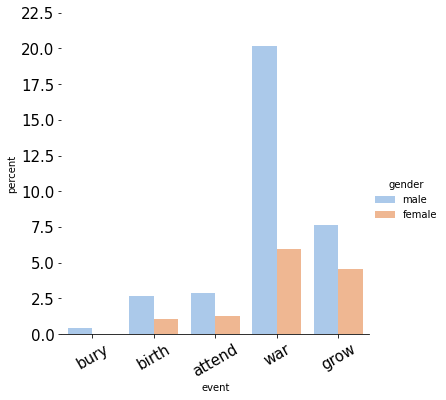

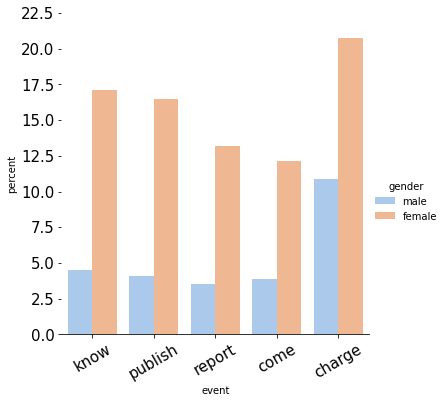

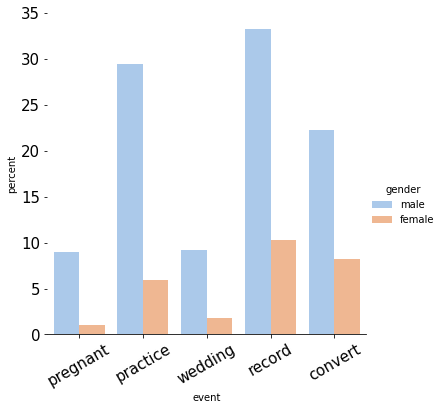

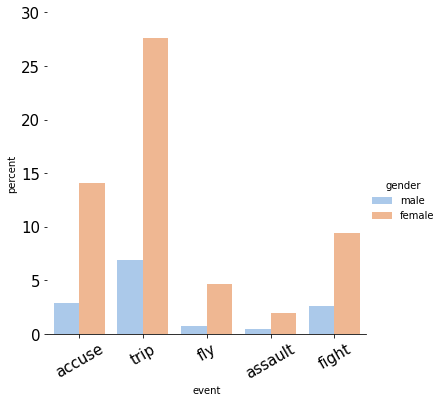

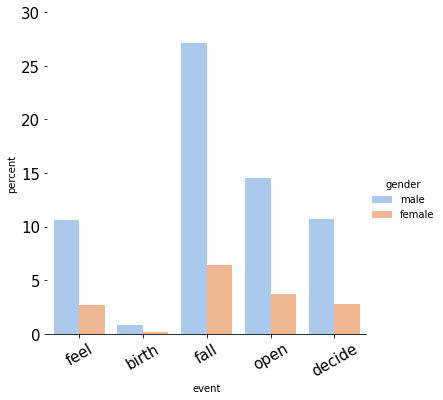

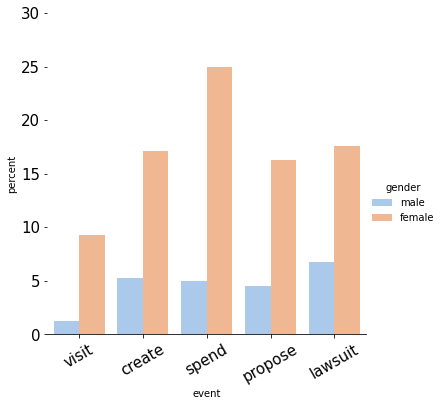

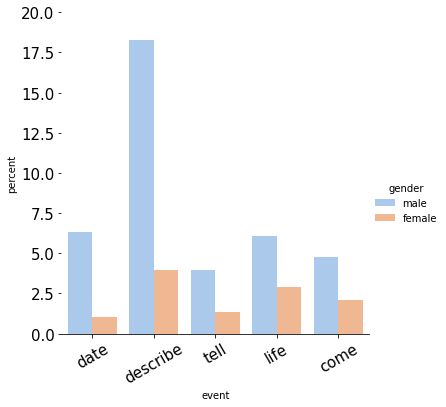

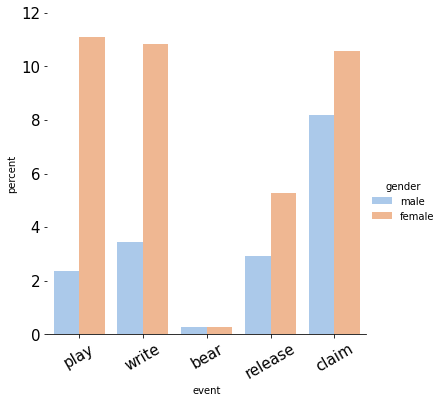

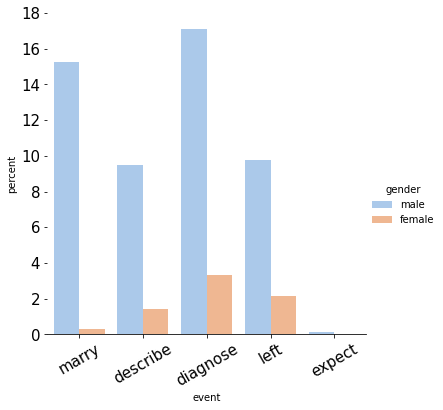

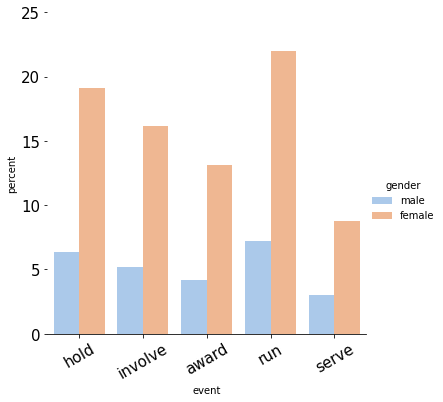

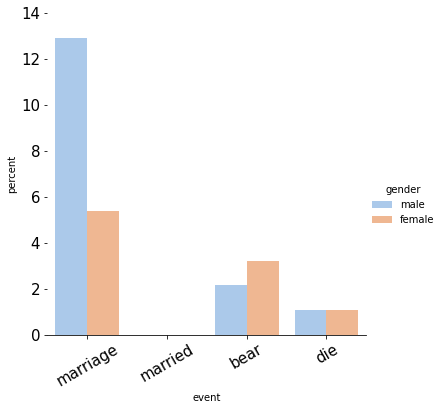

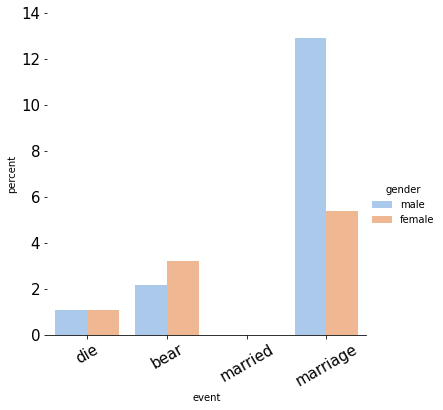

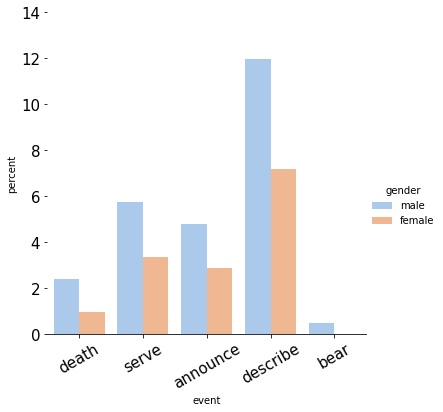

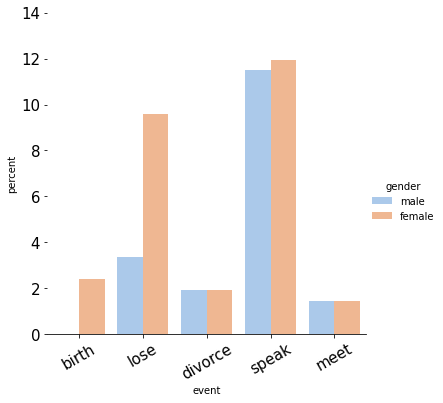

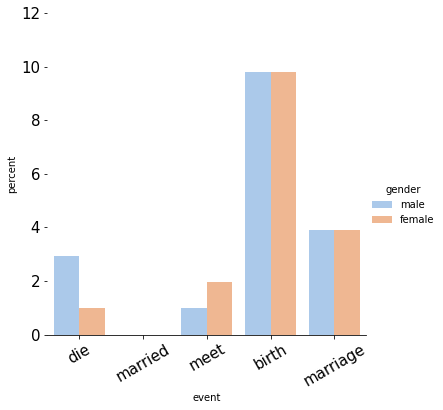

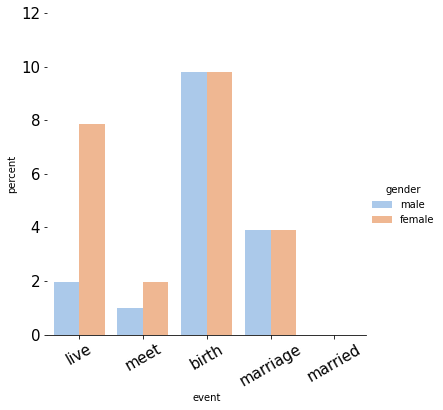

In [27]:
import seaborn as sns
import operator
for occu in new_occupations:
    print("Occupation: ", occu)
    m_dict_occu, f_dict_occu = odds_ratio(cali_result[occu]["F"], cali_result[occu]["M"])
    print("male: ", list(m_dict_occu.keys())[:10])
    print("female: ", list(f_dict_occu.keys())[:10])
    female_events = list(f_dict_occu.keys())[:5]
    male_events = list(m_dict_occu.keys())[:5]
    
    sorted_counter_f_pl = {k: v for k, v in sorted(cali_result[occu]["F"].items(), key=lambda item: item[1], reverse=True)}
    sorted_counter_m_pl = {k: v for k, v in sorted(cali_result[occu]["M"].items(), key=lambda item: item[1], reverse=True)}
    m_topic_pl = list(sorted_counter_m_pl.keys())
    f_topic_pl = list(sorted_counter_f_pl.keys())
    for gender in ["F", "M"]:
        position = []
        if gender == "F":
            select_events = female_events
        else:
            select_events = male_events
        
        for m_topic in select_events:
            position.append({
                "percent": m_topic_pl.index(m_topic) / len(m_topic_pl) * 100,
                "gender": "male",
                "event": m_topic
                })
            position.append({
                "percent": f_topic_pl.index(m_topic) / len(m_topic_pl) * 100,
                "gender": "female",
                "event": m_topic
                })

        df = pd.DataFrame(position)
        g = sns.catplot(x='event', y='percent', hue='gender', data=df, kind='bar', palette = sns.color_palette("pastel"))
        g.set_xticklabels(fontsize = 15, rotation=30)
        g.set_yticklabels(fontsize = 15)
        g.despine(left=True)    
        g.savefig(f"pl_figs/{occu}_{gender}.pdf", dpi=1000)